# Machine Learning Final Project: EEG-Based Brain-Computer Interface Using Machine Learning Methods

## Import Libraries

In [2]:
import mne
import pywt
import random
import scipy.io
import numpy as np
import seaborn as sns
from scipy.fft import fft 
from mne.decoding import CSP
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,\
    confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import roc_curve, RocCurveDisplay, roc_auc_score

from sklearn.cluster import KMeans
from sklearn.metrics import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

## Import Dataset

In the first run of the project we will use the "BCICIV_calib_ds1a" dataset. Later, we will also use a separate dataset, the "BCICIV_calib_ds1c", to perfrom all the signal processing steps and then finally perfom classification and clustering. At the end, we will compare their results.

In [5]:
# Load .mat file containing the EEG signals
mat = scipy.io.loadmat("/kaggle/input/bciciv-calib-ds1a/BCICIV_calib_ds1a.mat")
print("Variables include: ", mat.keys())

# Extract variables
cnt = mat['cnt'].astype(np.float64) * 0.1  # Converted microvolts
pos = mat['mrk']['pos'][0][0].flatten()
y = mat['mrk']['y'][0][0].flatten()

# Extract extra info
nfo = mat['nfo']
fs = nfo['fs'][0][0][0][0]
clab = [str(c[0]) for c in nfo['clab'][0][0][0]]
classes = [str(c[0]) for c in nfo['classes'][0][0][0]]
xpos = nfo['xpos'][0][0][0]
ypos = nfo['ypos'][0][0][0]

# Log
print(f"Number of time samples: {cnt.shape[0]}, Number of channels: {cnt.shape[1]}")
print(f"The list of classes is {classes}")

Variables include:  dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Number of time samples: 190594, Number of channels: 59
The list of classes is ['left', 'foot']


In this dataset the set of possible classes is the motor imagery of moving left hand or the feet.

## Explanatory Data Analysis

In [6]:
def visualize_EEG(cnt, title, clab, fs, channel_num=20):
    '''Input EEG data and visualize it using mne library'''
    # Create info metavariable
    info = mne.create_info(ch_names=clab, sfreq=fs, ch_types='eeg')

    # Create RawArray object
    raw = mne.io.RawArray(cnt.T, info)

    # Plot raw EEG data
    raw.plot(n_channels=channel_num, scalings='auto', title=title, bgcolor='white', color='darkblue')

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.
Using matplotlib as 2D backend.


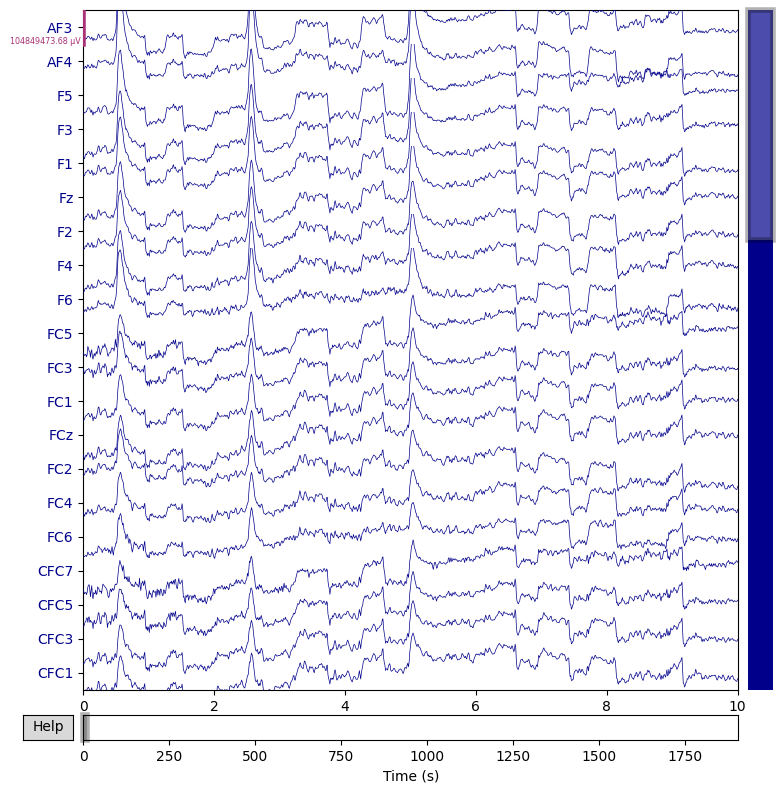

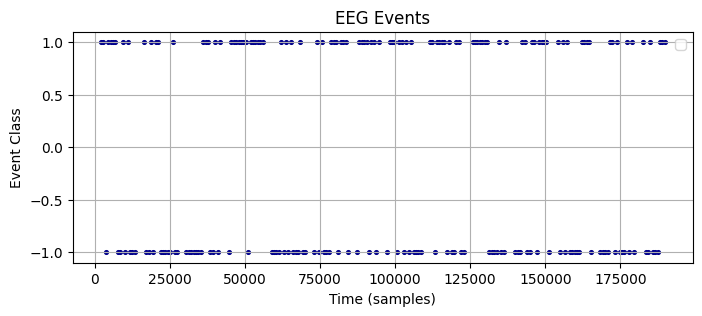

In [7]:
# Visualize raw EEG data
visualize_EEG(cnt, "Raw EEG Plot", clab, fs)

# Create a plot of events
plt.figure(figsize=(8, 3))
plt.scatter(pos, y, s=7.1, color="darkblue")
plt.xlabel('Time (samples)')
plt.ylabel('Event Class')
plt.title('EEG Events')
plt.legend()
plt.grid(True)
plt.show()

## Pre-Processing

### Band-Pass Filtering

In [8]:
def bandpass_filter(cnt, lo, hi, fs, order=3):
    tmp = 0.5 * fs
    low = lo / tmp
    high = hi / tmp
    b, a = scipy.signal.butter(order, [low, high], btype='band')
    result = scipy.signal.lfilter(b, a, cnt, axis=0)
    return result

In [9]:
# Apply the bandpass filter for 8-30 hrz
bandpass_cnt = bandpass_filter(cnt, 8, 30, fs)

Let us take a look at the new filtered EEG signals:

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


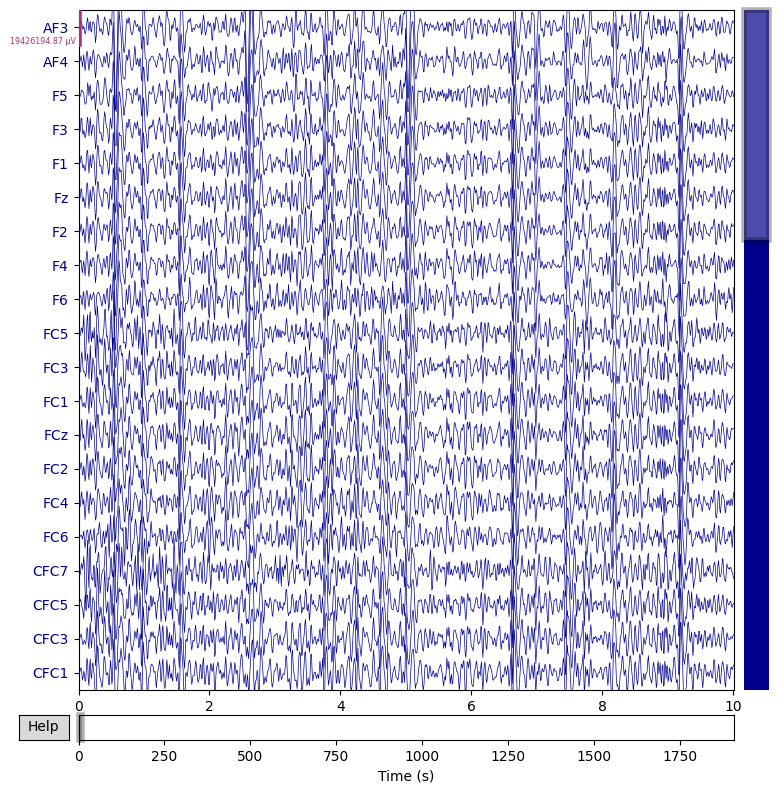

In [10]:
# Visualize bandpass filtered EEG data
visualize_EEG(bandpass_cnt, " EEG Plot", clab, fs)

### CAR
Now, we perform CAR as a spatial filter for decreasing noise and increasing the quality of the data set signals.

In [11]:
def common_average_reference(cnt):
    '''Calculate and return the CAR of given EEG data'''
    return cnt - np.mean(cnt, axis=1, keepdims=True)

In [12]:
# Apply CAR to reduce noise
CAR_cnt = common_average_reference(bandpass_cnt)

The data will look this way now:

Creating RawArray with float64 data, n_channels=59, n_times=190594
    Range : 0 ... 190593 =      0.000 ...  1905.930 secs
Ready.


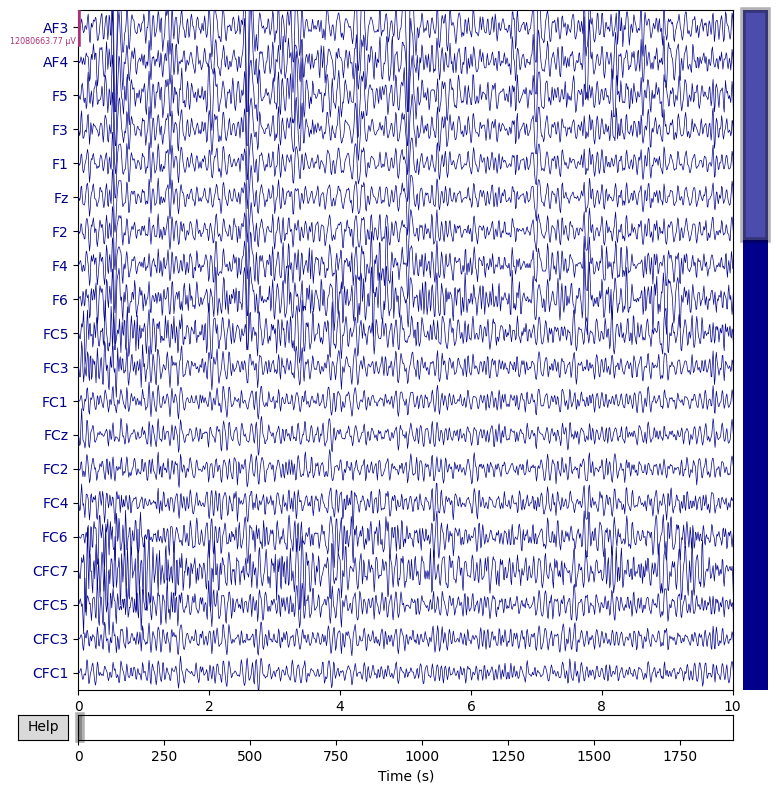

In [13]:
# Visualize bandpass filtered EEG data
visualize_EEG(CAR_cnt, "CAR Applied EEG", clab, fs)

To help understand the effects of these pre-processing methods on the data, now we will take a look at a portion of a single channel. This way, we can inspect the effects of these filters more closely.

In [14]:
def visualize_contrast(cnt_list, label_list):
    """
    Input a list of distinct EEG data and their respective names
    and plot them agains each other to display their differences
    and contrast.
    """
    fig, ax = plt.subplots(figsize=(15,6))
    for cnt, label in zip(cnt_list, label_list):
        ax.plot(cnt, label=label, linewidth=2)
    fig.legend()
    ax.set_xlabel("Time")
    ax.set_ylabel("Voltage")
    ax.set_xlim(0, 500)
    fig.show()

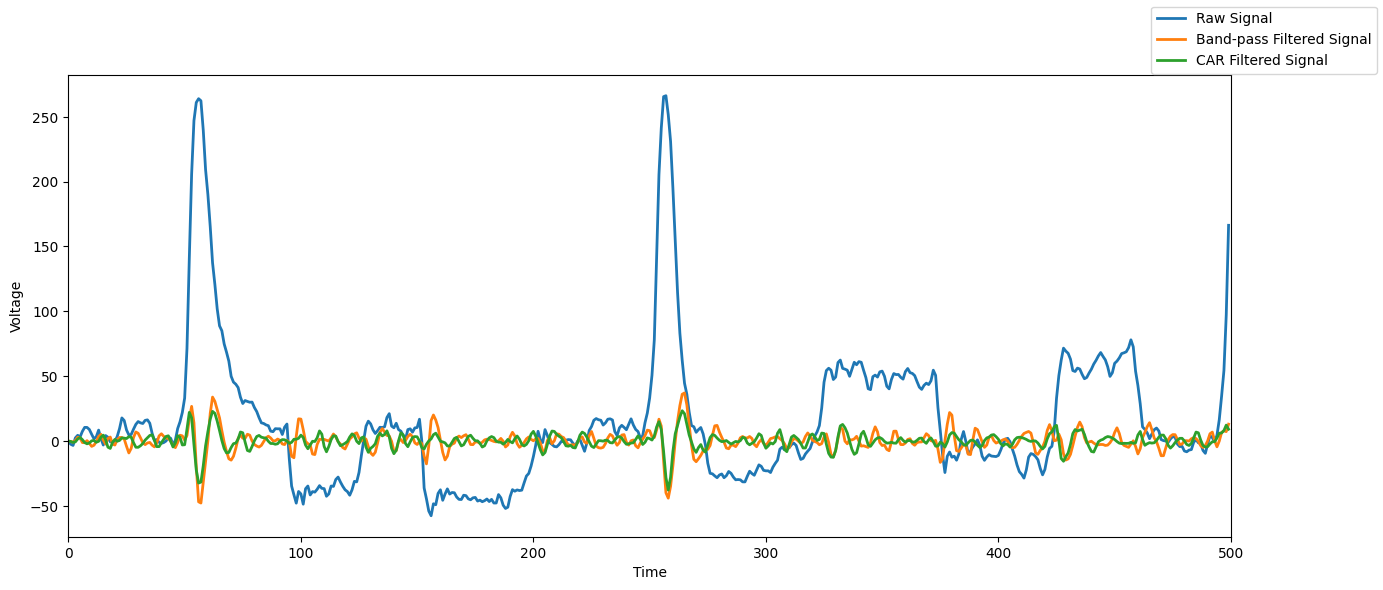

In [15]:
# List of EEG's to visualize
cnt_list_1 = [cnt[:500, 0], bandpass_cnt[:500, 0], CAR_cnt[:500, 0]]
label_list_1 = ["Raw Signal", "Band-pass Filtered Signal", "CAR Filtered Signal"]

# Visualize them against one another
visualize_contrast(cnt_list_1, label_list_1)

For further visualization, we can use t-SNE representation to show the data in higher dimensions (more channels). The following code block takes slightly longer to complete.

In [16]:
# Apply t-SNE to 2D
tsne = TSNE(n_components=2)
tsne_cnt1 = tsne.fit_transform(CAR_cnt[:500, :])
tsne_cnt2 = tsne.fit_transform(bandpass_cnt[:500, :])
tsne_cnt3 = tsne.fit_transform(cnt[:500, :])

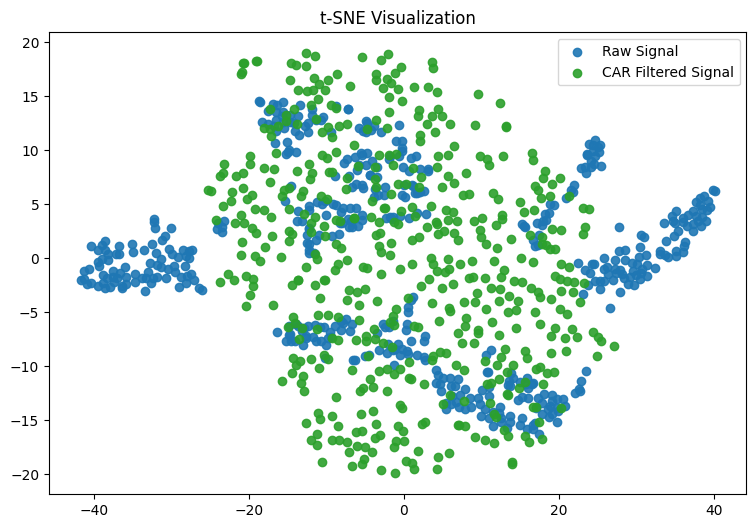

In [17]:
# Plot the t-SNE visualization
fig, ax  = plt.subplots(figsize=(9,6))
plt.scatter(tsne_cnt3[:, 0], tsne_cnt3[:, 1], alpha=0.9, label="Raw Signal")
plt.scatter(tsne_cnt2[0:0, 0], tsne_cnt2[0:0, 1], alpha=0.8)
plt.scatter(tsne_cnt1[:, 0], tsne_cnt1[:, 1], alpha=0.9, label="CAR Filtered Signal")
plt.title('t-SNE Visualization')
plt.legend()
plt.show()

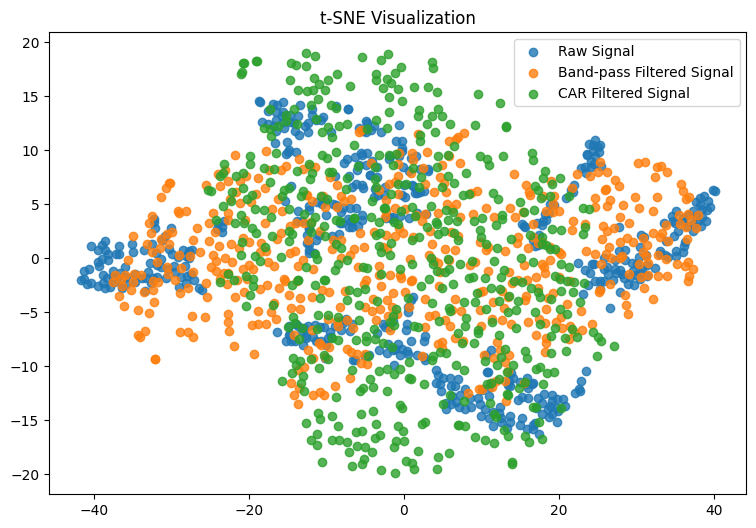

In [18]:
# Plot the t-SNE visualization
fig, ax  = plt.subplots(figsize=(9,6))
plt.scatter(tsne_cnt3[:, 0], tsne_cnt3[:, 1], alpha=0.8, label="Raw Signal")
plt.scatter(tsne_cnt2[:, 0], tsne_cnt2[:, 1], alpha=0.8, label="Band-pass Filtered Signal")
plt.scatter(tsne_cnt1[:, 0], tsne_cnt1[:, 1], alpha=0.8, label="CAR Filtered Signal")
plt.title('t-SNE Visualization')
plt.legend()
plt.show()

### Principal Component Analysis

For cleaning and denoising the data further, now we will implement and analyze the PCA dimensionality reduction method.

In [19]:
def principal_component_analysis(data, n_components='mle', verbose=False):
    '''Perform PCA to reduce noise and reduce dimensionality.'''
    
    # Initialize PCA 
    pca = PCA(n_components=n_components)
    
    # Reshape the data for applying PCA
    n_epochs, n_times, n_channels = data.shape
    data = data.reshape(-1, n_channels)
    
    # Apply PCA
    principal_components = pca.fit_transform(data)
    
    # Reshape it back
    principal_components = principal_components.reshape(n_epochs, n_times, -1)
    
    # Variance info
    if verbose:
        print(principal_components.shape)
        print(pca.explained_variance_ratio_)
        
    return principal_components

### Independent Component Analysis

In [20]:
def independent_component_analysis(data, n_components=50):
    '''Perform ICA for more noise reduction'''
    
    # Initialize ICA 
    ica = FastICA(n_components=n_components, random_state=42)
    
    # Reshape the data for applying ICA
    n_epochs, n_times, n_channels = data.shape
    data = data.reshape(-1, n_channels)
    
    # Apply PCA
    independent_components = ica.fit_transform(data)
    
    # Reshape it back
    independent_components = independent_components.reshape(n_epochs, n_times, -1)
    
    return independent_components

## Segmenting the Dataset

We will segment the dataset into different epochs around the cue positions given to us in the dataset.

In [21]:
def segment_data(cnt, y, a=0, b=1000): 
    """
    Segment the data into different segments or epochs
    around the cue position to perform classification on.
    
    Parameter
    ---------
    cnt : numpy.ndarray
        A 2D NumPy array of size (m, n) where 'm' is the
        number of time samples and 'n' is the number of
        EEG channels (number of electrodes).
    y : numpy.ndarray
        A 1D numpy array containing the target variables
        for each of the cue positions.
    a : int
        Number of milliseconds after cue positions to
        choose as the start of the segment.
    b : int
        Number of milliseconds after cue positions to
        choose as the end of the segment.
        
    Returns
    -------
    segments : numpy.ndarray
        A 3D NumPy array acting as a list of the 
        segments.
        
    segment_targets : numpy.ndarray
        A 1D NumPy array containing the target values.
    """
    
    # Segment start and end parameters in milliseconds.
    segment_start = a
    segment_end = b 

    # Create the segments.
    segments = []
    segment_targets = []

    # Go through every cue position.
    for i, cue_pos in enumerate(pos):
        left = cue_pos + segment_start
        right = cue_pos + segment_end
        
        # Make sure no out of bounds.
        if left >= 0 and right <= cnt.shape[0]:
            segments.append(cnt[left:right,:])
            segment_targets.append(y[i])
    
    # Return as NumPy arrays
    segments_np = np.array(segments)
    segment_targets_np = np.array(segment_targets)
    
    return segments_np, segment_targets_np

In [22]:
# Segment the data to be used for model training
seg_data, labels = segment_data(CAR_cnt, y, -50, 350)
seg_data.shape

(200, 400, 59)

## Feature Extraction


### Common Spatial Patterns (CSP)

In [23]:
def common_spatial_patterns(data, labels, component_num=45, reg=None, plot=False):
    """
    Apply CSP using given data and their labels.
    
    Parameters
    ----------
    data : numpy.ndarray
        A 3D NumPy array of shape (n_epochs, n_times, n_channels)
        representing the data the CSP will be applied to.
        The order of n_times and n_channels here is according to 
        the dataset.
        
    labels: numpy.ndarray
        A 1D array containig the labels for each of the epochs.
        
    component_num : int
        Representing the number of components (features) to be 
        extracted using CSP.
        
    reg : None or string or float
        Type of regularization chosen for CSP.
        
    plot : bool
        If true, plot the CSP patterns. Otherwise do not.
        
    Returns
    -------
    csp_data : numpy.ndarray
        A 2D array of shape (n_epochs, n_components) containig 
        the CSP applied data. 
    
    """
    
    # Transpose 2nd and 3rd components to be compatible with the 
    # MNE library function calls: (n_epochs, n_channels, n_times)
    csp_ready_data = data.transpose(0, 2, 1)

    # Initialize CSP for feature extraction.
    csp_obj = CSP(n_components=component_num, reg=reg, log=True)

    # Fit and apply the CSP using labels.
    csp_data = csp_obj.fit_transform(csp_ready_data, labels)
    
    # Plot CSP patterns if plot=True
    if plot:
        plot_csp(csp_obj, component_num)
    
    # Return CSP applied data
    return csp_data


def plot_csp(csp_obj, component_num):
    '''Plot the CSP features'''
    plt.figure(figsize=(15, 5))
    for i in range(component_num):
        plt.plot(csp_obj.patterns_[i], label=f'CSP Pattern {i+1}')
#     plt.legend()
    plt.title('CSP Patterns Visualized')
    plt.show()

Computing rank from data with rank=None
    Using tolerance 1.2e+02 (2.2e-16 eps * 59 dim * 8.9e+15  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


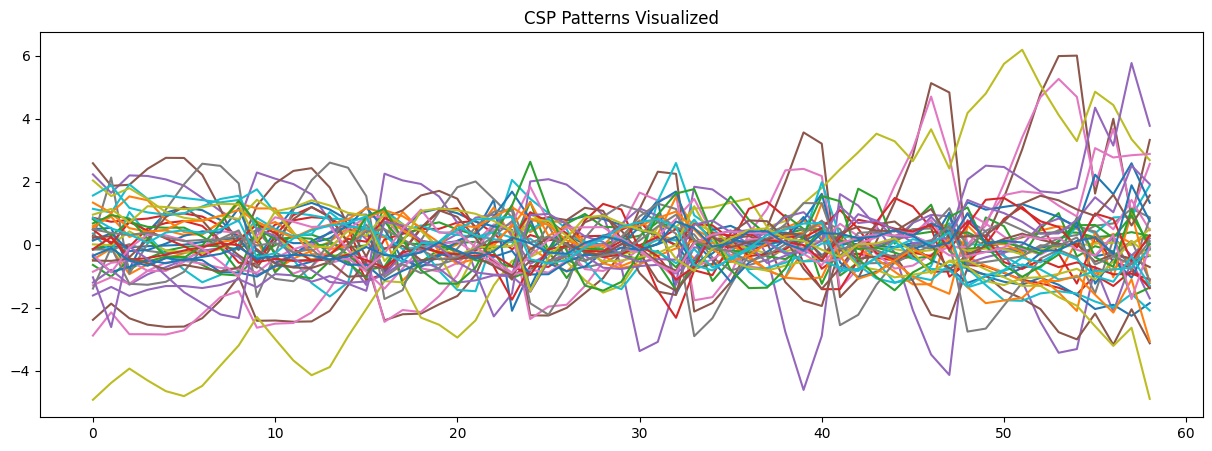

In [24]:
# Apply CSP
csp_data = common_spatial_patterns(seg_data, labels
                                   , component_num=41, plot=True)

Now let us plot the features extracted using the CSP and see how much they can separate out the classes. Since the data has high dimensionality, we will first plot the features using some pairs of two randomly selected components only and then plot it using t-SNE.

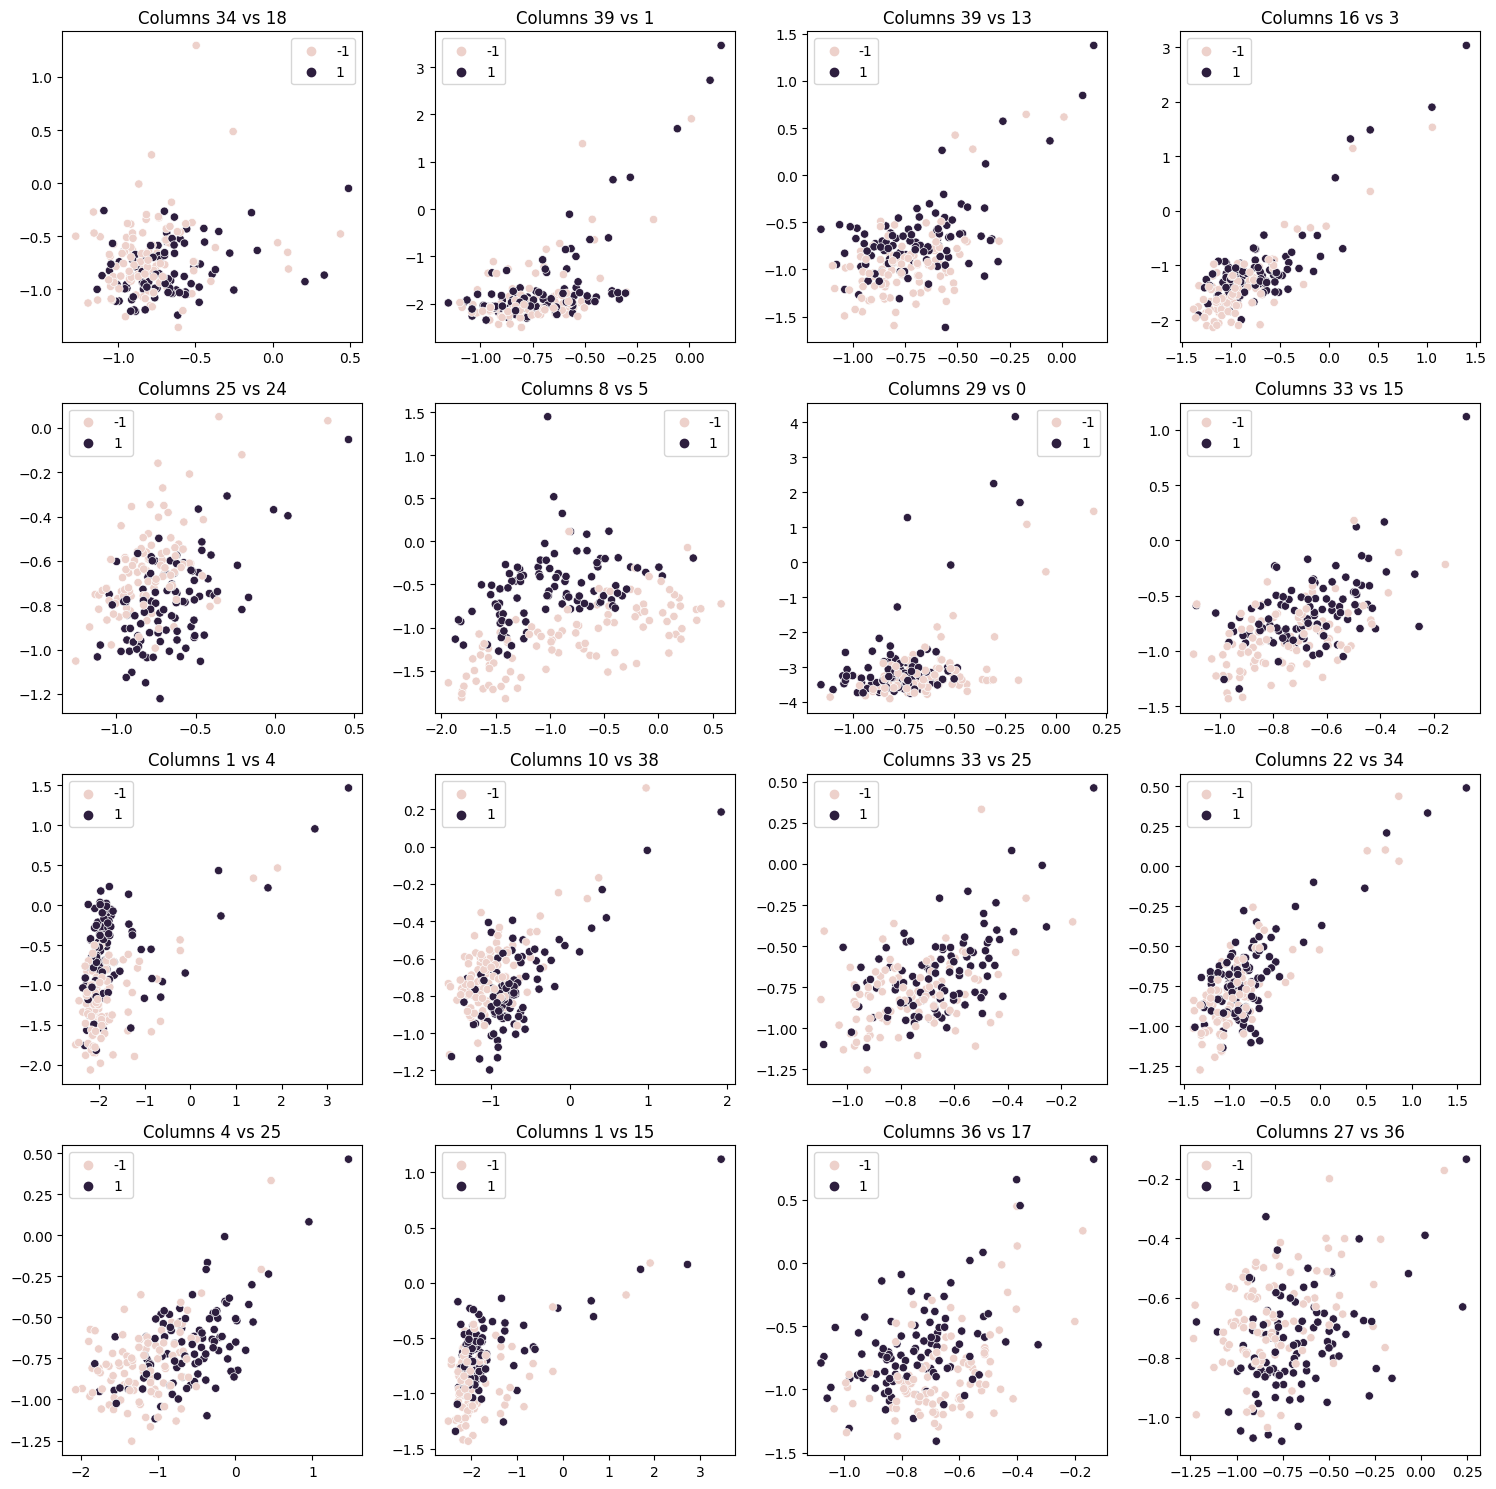

In [25]:
num_plots = 16
size = int(np.sqrt(num_plots))
fig, axes = plt.subplots(size, size, figsize=(15, 15))

# Seed for repeating results
random.seed(30)

# Create scatter plots
for i in range(size):
    for j in range(size):
        # Randomly select two columns
        x_column, y_column = random.sample(range(41), 2)
        sns.scatterplot(x=csp_data[:, x_column], y=csp_data[:, y_column], hue=labels, ax=axes[i, j])
        axes[i, j].set_title(f'Columns {x_column} vs {y_column}')

# Adjust layout
plt.tight_layout()
plt.show()

In [26]:
def plot_tsne_feature_extract(data, labels, pca=False, title="CSP-Dataset A"):
    """
    Plot the t-SNE of the feature extraction methods produced results to 
    analyze the separation created by it between the classes.
    """
    
    perplexities = [30, 30, 50, 50, 30, 50, 5, 30, 50, 5, 30, 50, 50, 30, 50, 5]
    n_iters = [1000, 3000, 5000, 5000, 1000, 3000, 1000, 3000, 5000, 1000, 3000,
               5000, 5000, 1000, 3000, 1000]
    metrics = ["euclidean", "euclidean", "euclidean", "euclidean", 
               "euclidean", "euclidean", "euclidean", "euclidean", 
               "manhattan", "manhattan", "manhattan", "manhattan", 
               "cosine", "cosine", "cosine", "cosine" ]

    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20, 20))
    axes = axes.flatten()
    
    # Apply PCA before t-SNE if pca=True
    if pca:
        pca_obj = PCA(n_components=50)
        data = pca_obj.fit_transform(data)

    for i, (perplexity, n_iter, metric) in enumerate(zip(perplexities, n_iters, metrics)):
        ax = axes[i]
        tsne_2D = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto", n_iter=n_iter, metric=metric, random_state=42)
        tsne_res = tsne_2D.fit_transform(data)

        ax.scatter(tsne_res[labels == 1, 0], tsne_res[labels == 1, 1], label="Class 1", color='b')
        ax.scatter(tsne_res[labels == -1, 0], tsne_res[labels == -1, 1], label="Class -1", color='r')
        ax.set_title(f'Perplexity: {perplexity}, Iter: {n_iter}, Metric: {metric}')
        ax.legend()
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    fig.suptitle(f"t-SNE Plot of the features : {title}")
    plt.show()

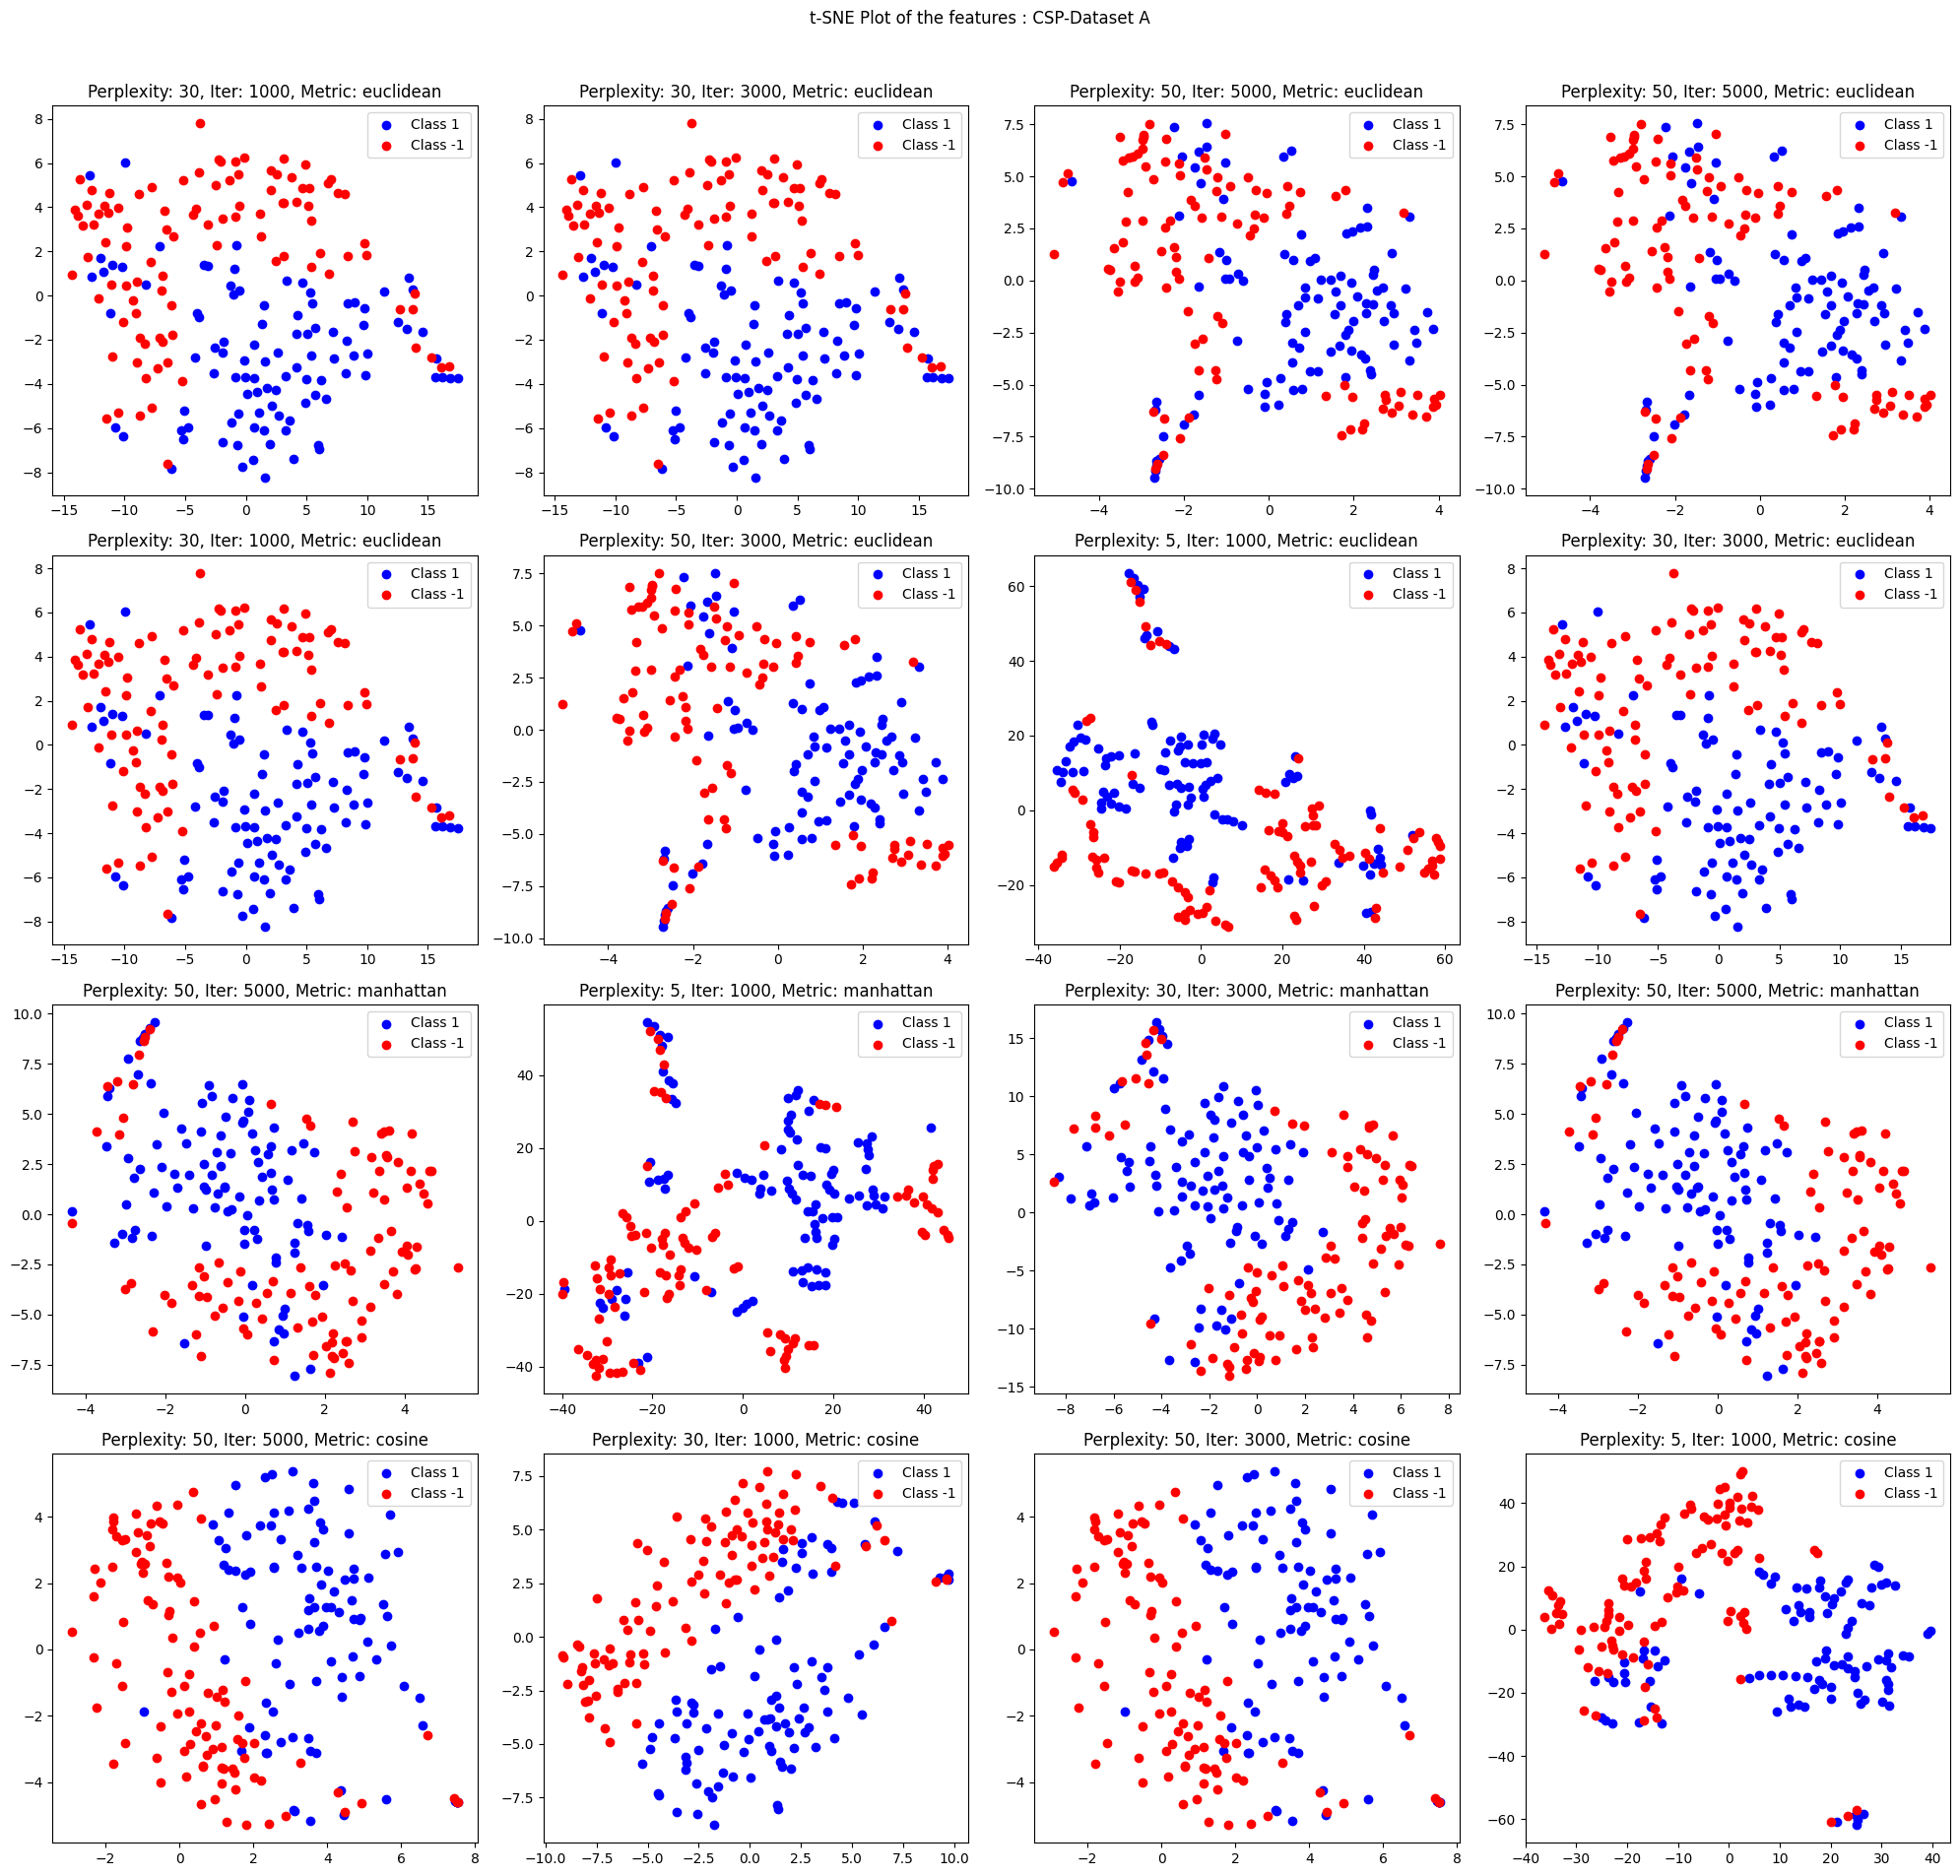

In [30]:
plot_tsne_feature_extract(csp_data, labels)

### Fast Fourier Transform

Another feature extraction method is to use the FFT to compute the discrete fourier transform of the EEG data to bring it into the frequency domain. We will use the magnitude of the FFT results as features. One advantage the FFT has over the CSP is that it does not need label data. However, as we will see in rest of the notebook, this method leads to poorer performance from the classifiers.

In [31]:
def fast_fourier_transform(data, fs):
    """
    Calcuate discrete Fourier transform using the FFT algorithm.
    
    parameters
    ----------
    data : numpy.ndarray
        The input data in the shape of (n_epochs, n_times, n_channels).
        
    fs : int
        The sampling frequency.
        
    returns
    -------
    dft : numpy.ndarray
        The resulting DFT. To use it or its magnitude as features for a
        classifiers to learn from, flatten its shape of (n_epochs, n_channels, 
        n_times // 2 + 1) into (n_epochs, n_channels * (n_times // 2 + 1)).
        
    frequencies : numpy.ndarray
        Frequency values of the FFT.
    """
    
    # Prepare the data
    data = data.transpose(0, 2, 1)
    
    # Get the dimensions
    n_epochs, n_channels, n_times = data.shape
    
    # Array with complex data types to store the discrete fourier 
    # transform for each epoch and channel pair. Only use the 
    # n_times // 2 + 1 due to the symmetry in the DFT.
    dft = np.zeros((n_epochs, n_channels, n_times // 2 + 1), dtype=complex)
    
    # Go through every epoch channel combination and perform fft
    for i in range(n_epochs):
        for j in range(n_channels):
            dft[i, j, :] = fft(data[i, j, :])[:n_times // 2 + 1]
            
    # Calculate frequencies
    frequencies = np.fft.fftfreq(n_times, 1 / fs)[:n_times//2 + 1]
    
    return dft, frequencies

In [32]:
# Apply FFT
fft_results, frequencies = fast_fourier_transform(seg_data, fs)
abs_fft_data = np.abs(fft_results)

# Flatten to feed into classifiers
fft_data = abs_fft_data.reshape(fft_results.shape[0], -1) 

To visualize the resulting features of FFT, we will use the t-SNE plot. First PCA will be applied to the data to reduce the number of components and then t-SNE is applied.

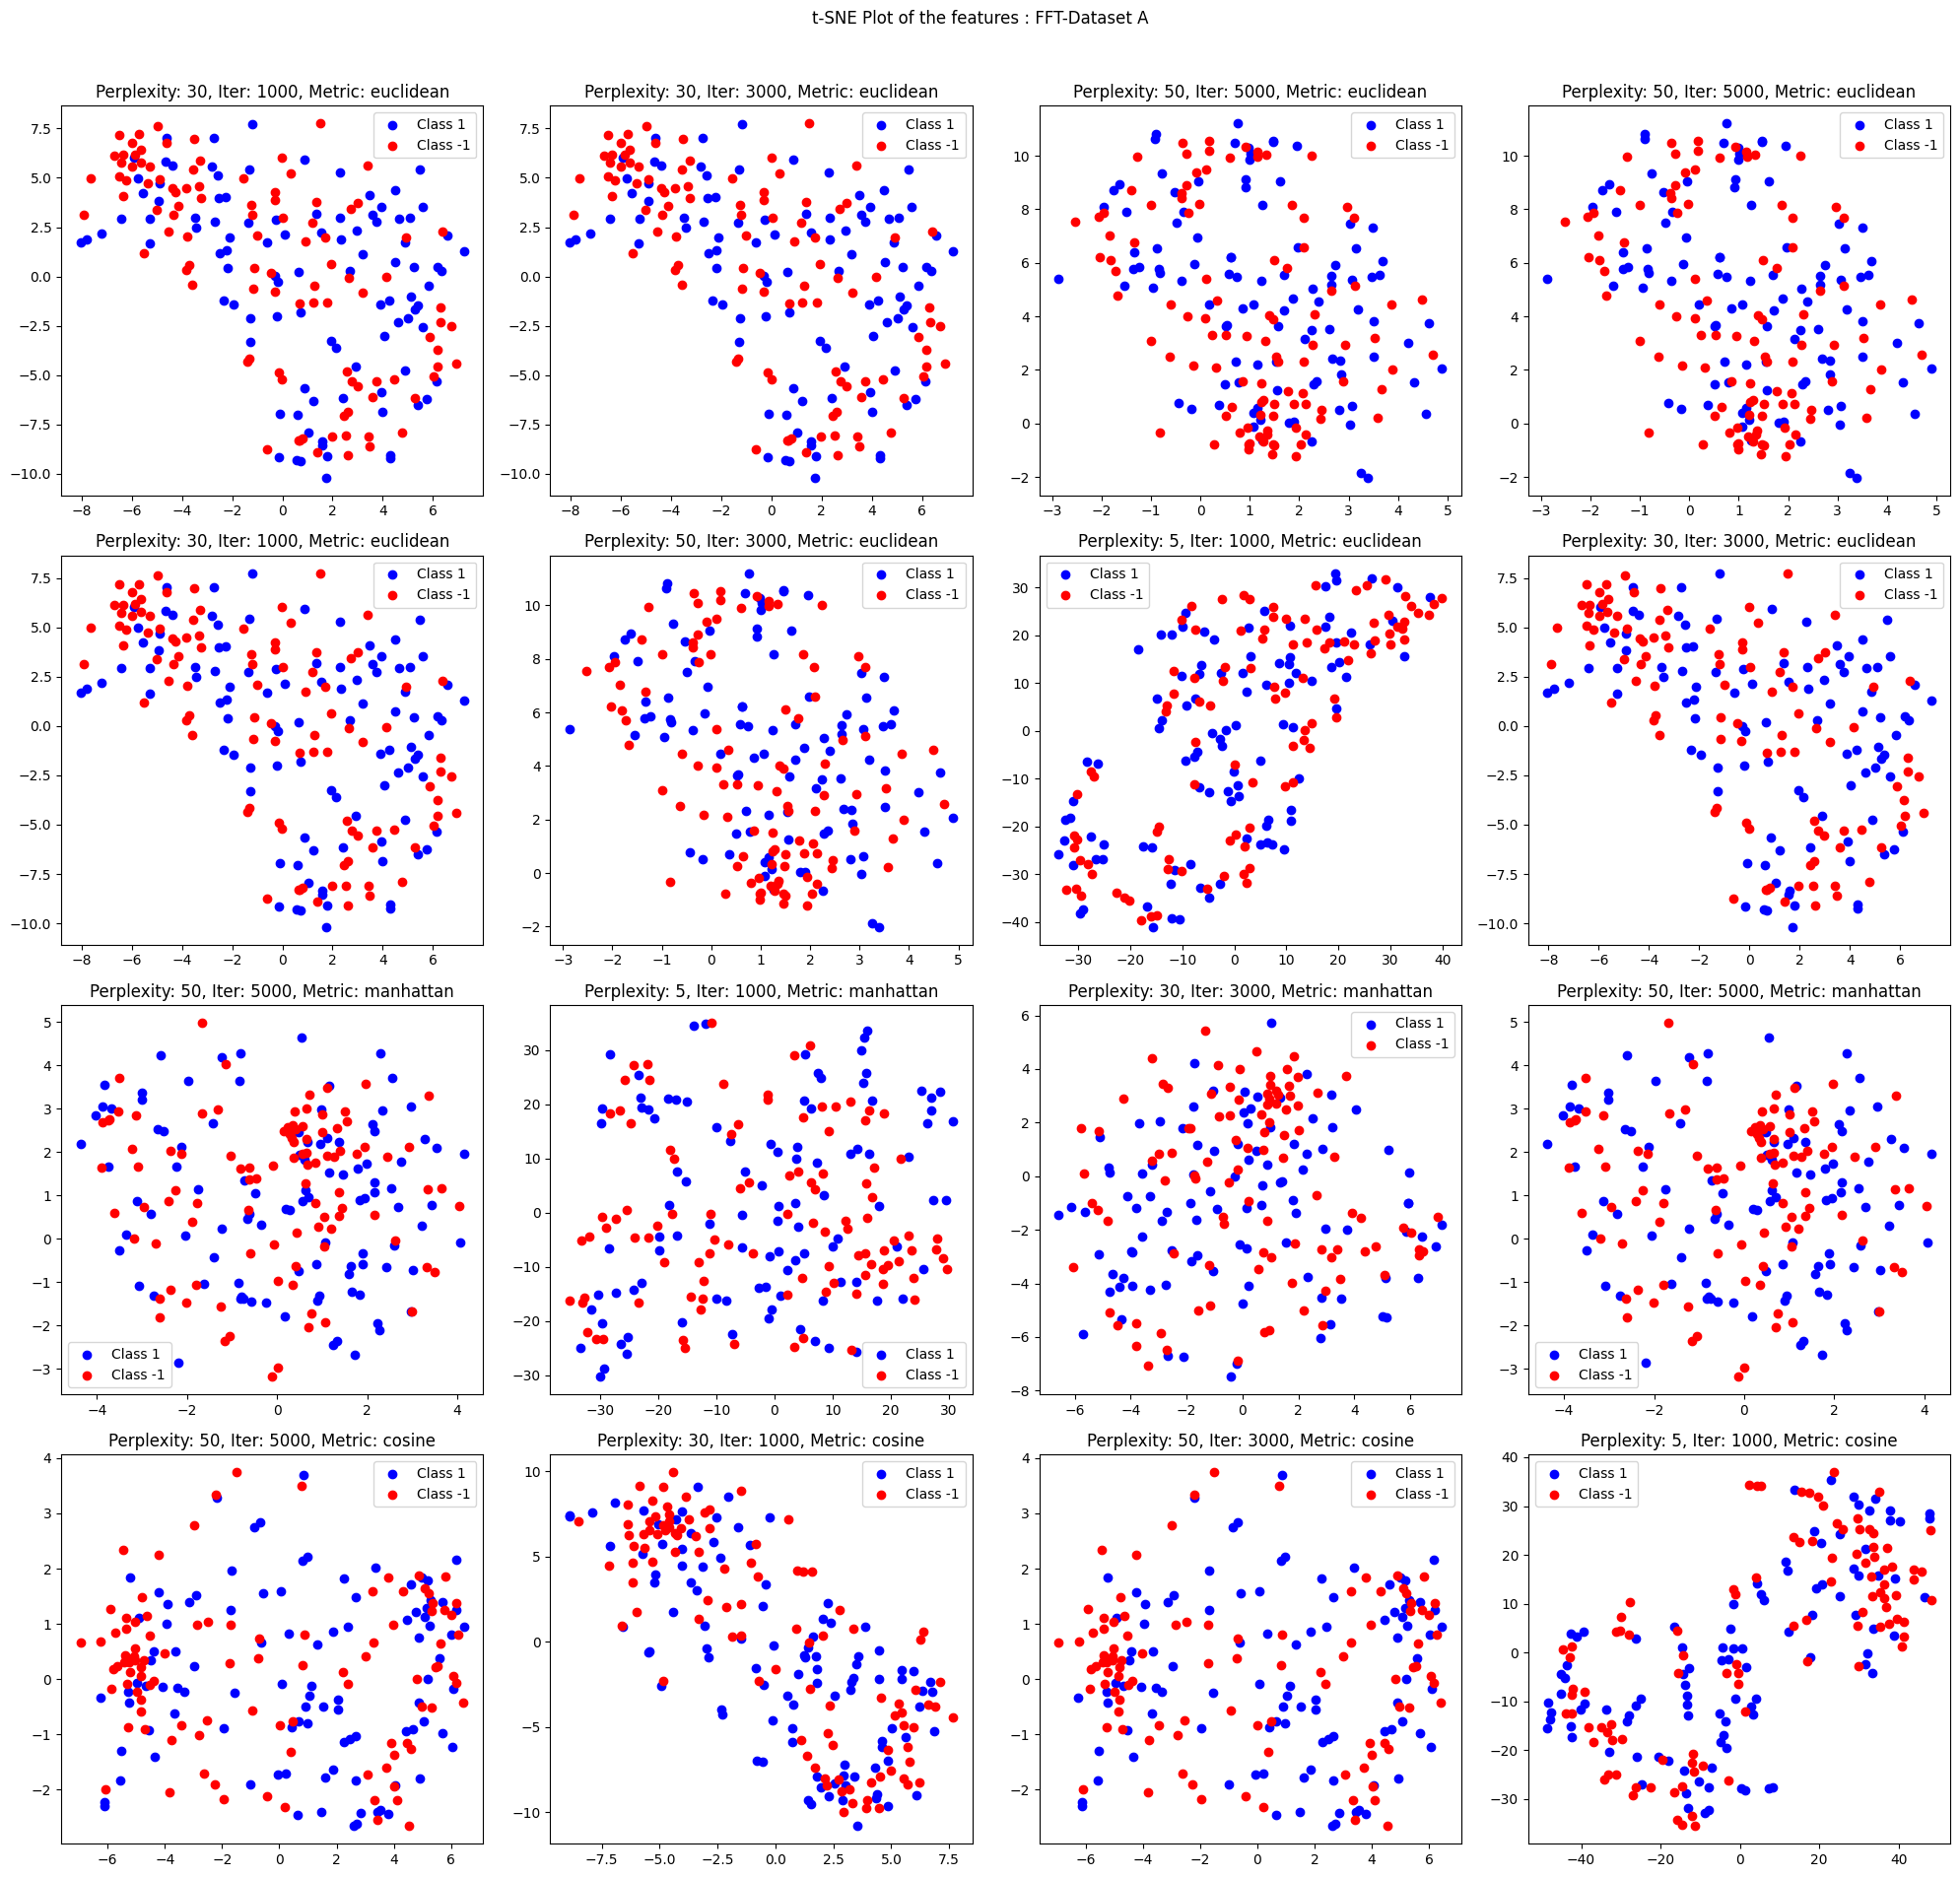

In [35]:
plot_tsne_feature_extract(fft_data, labels, pca=True, title="FFT-Dataset A")

### Wavelet Transform

Another method that improves on the fourier transform is the continuous wavelet transform.

In [36]:
def continuous_wavelet_transform(data, wavelet='morl', scales=np.arange(1, 128)):
    """
    Apply continuous wavelet transfrom (CWT) to EEG data.
    
    Parameters
    ----------
    data : numpy.ndarray 
        The EEG data of shape (n_epochs, n_times, n_channels).
    wavelet : str
        The type of wavelet to use (default = 'morl').
    scales : numpy.ndarray 
        The scales to use for the CWT, deciding which frequencies
        to value.
    
    Returns
    -------
    results : numpy.ndarray 
        The CWT applied on the data
    """
    
    # Transpose 2nd and 3rd component
    data = data.transpose(0, 2, 1)
    
    n_epochs, n_channels, n_times = data.shape
    
    # Store results
    result = []
    
    # Compute CWT for each epoch and channel combo
    for i in range(n_epochs):
        epoch_cwt = []
        for j in range(n_channels):
            cwt, _ = pywt.cwt(data[i, j, :], scales, wavelet)
            epoch_cwt.append(cwt)
        result.append(epoch_cwt)
        if i % 50 == 49:
            print(f"Epoch {i + 1} completed")
            
    print("Finished!")
    
    # Return as NumPy array
    return np.array(result)

In [37]:
# Apply CWT
cwt_results = continuous_wavelet_transform(seg_data, scales=np.array([32]), wavelet="morl")

# Flatten to feed to ML models
cwt_data = cwt_results.reshape(cwt_results.shape[0], -1)

Epoch 50 completed
Epoch 100 completed
Epoch 150 completed
Epoch 200 completed
Finished!


To visualize features extracted using the CWT, we will use the t-SNE plot in the same way as we did with the FFT features.

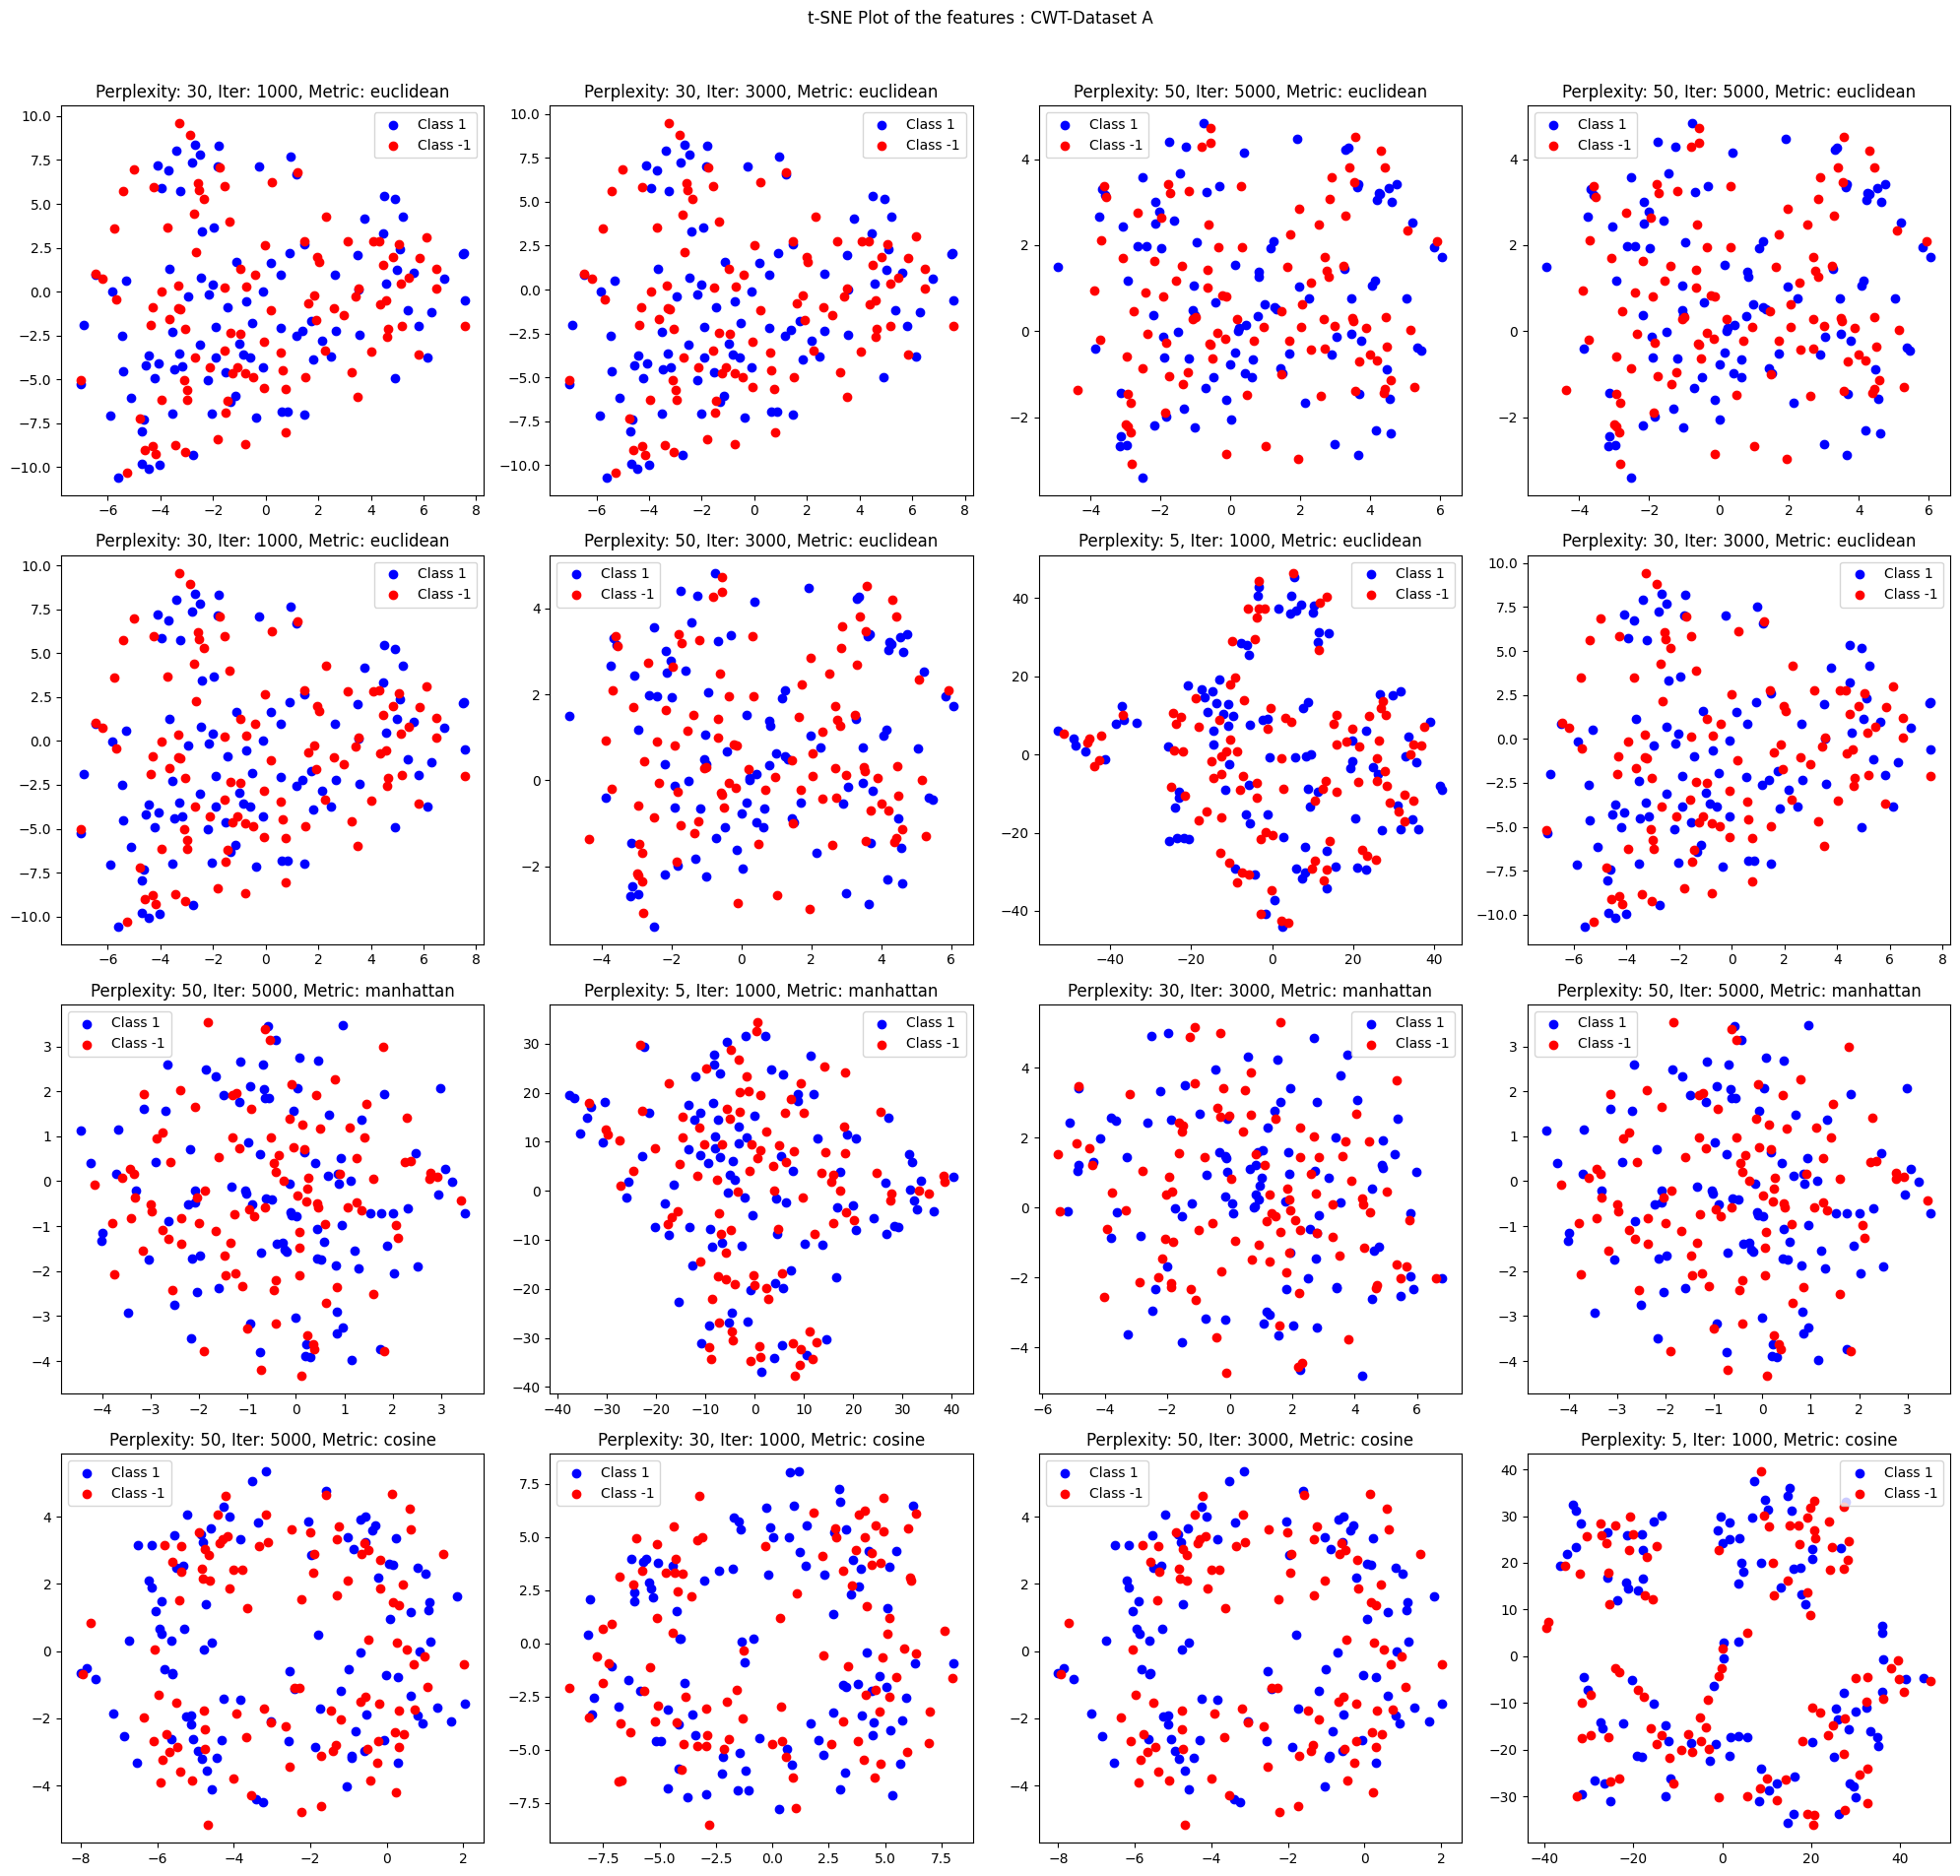

In [38]:
plot_tsne_feature_extract(cwt_data, labels, pca=True, title="CWT-Dataset A")

## Classification

The first step here is to normalize (standardize) the newly segmented data and then split it into train/test sets with 75-25 ratio. This will be done such that the relative ratio between the frequency of the two classes is maintained in both of the train and data sets.

### Train/Test Split

In [39]:
def train_test_normalize_split(X, y, normalize=True):
    """
    Split the data into 75-25 train/test data and standardize 
    them if normalize flag is True.
    """
    # Standardize the data if normalize=True
    if normalize:
        # Initialize standardiztion transform
        scaler = StandardScaler()

        # Apply standardization
        X = scaler.fit_transform(X)
        
    # Split the data    
    return train_test_split(X, y,\
        train_size=0.75, random_state=35, stratify=y)

In [40]:
# Normalize and split the data
X_train, X_test, y_train, y_test = train_test_normalize_split(csp_data, labels)

### Models


In [41]:
def fit_classify(X_train, X_test, y_train, y_test, clf_num=3):
    """
    Train different classifiers and use them to perform classification
    using the same training and test sets.
    
    Parameters
    ----------
    X_train, X_test, y_train, y_test : numpy.ndarray
        Training and test sets and labels.
        
    clf_num : int
        Number of classifiers to be selected for the task. There is a
        priority set in place for which classifiers to select.
    
    Returns
    -------
    None
    """

    # List of classifiers to train
    clf_list = [SVC(kernel="linear", C=0.5, probability=True)
                , SVC(kernel="rbf", C=1, gamma='auto', probability=True)  
                , LogisticRegression()
                , MLPClassifier(hidden_layer_sizes=(100, 50, 10), alpha=0.005)
                , KNeighborsClassifier(n_neighbors=3)
                , RandomForestClassifier(n_estimators=50)
                , GradientBoostingClassifier(n_estimators=50)
                , AdaBoostClassifier(n_estimators=50)]
    
    # And their names
    clf_names = [ "Support Vector Machine with Linear Kernel"
                , "Support Vector Machine with RBF Kernel"
                , "Logistic Regression"
                , "Multilayer Perceptron"
                , "K-Nearest Neighbors" 
                , "Random Forest" 
                , "Gradient Boosting"
                , "AdaBoost"]
    
    clf_num = min(clf_num, len(clf_list))

    # Go through each classifier
    for i, (clf, clf_name) in enumerate(zip(clf_list[:clf_num], clf_names[:clf_num])):
        # Train on training set
        clf.fit(X_train, y_train)

        # Make prediction
        y_pred = clf.predict(X_test)

        # Evaluate model performance
        print()
        print(f"----------------------- {i + 1}. {clf_name} -----------------------")
        print()
        
        # Accuracy
        print(f'{clf_name} Accuracy: {accuracy_score(y_test, y_pred)*100}%')
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        cm_display = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
        print(cm)
        cm_display.plot(cmap="Blues"); plt.show()
        
        # ROC curve
        y_probabilities = clf.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_probabilities)
        roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)
        roc_display.plot(); plt.show()


----------------------- 1. Support Vector Machine with Linear Kernel -----------------------

Support Vector Machine with Linear Kernel Accuracy: 98.0%
              precision    recall  f1-score   support

          -1       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

[[24  1]
 [ 0 25]]


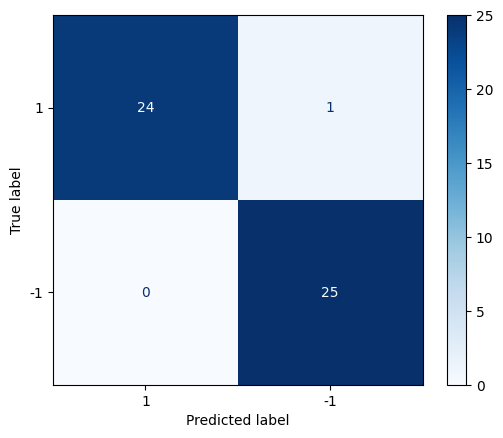

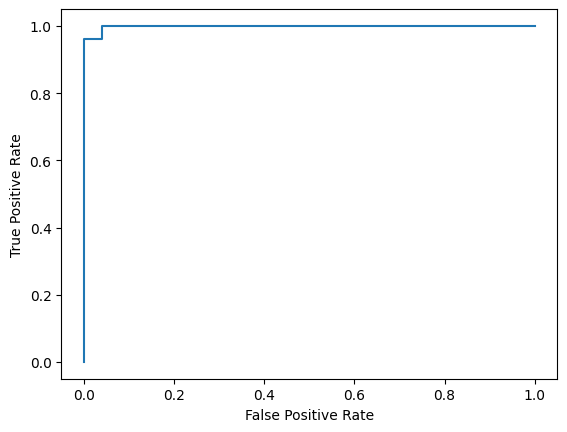


----------------------- 2. Support Vector Machine with RBF Kernel -----------------------

Support Vector Machine with RBF Kernel Accuracy: 92.0%
              precision    recall  f1-score   support

          -1       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

[[24  1]
 [ 3 22]]


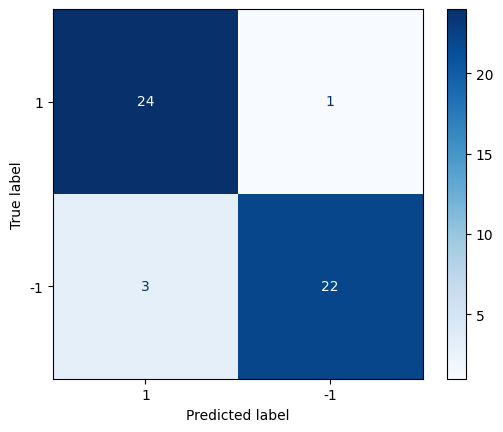

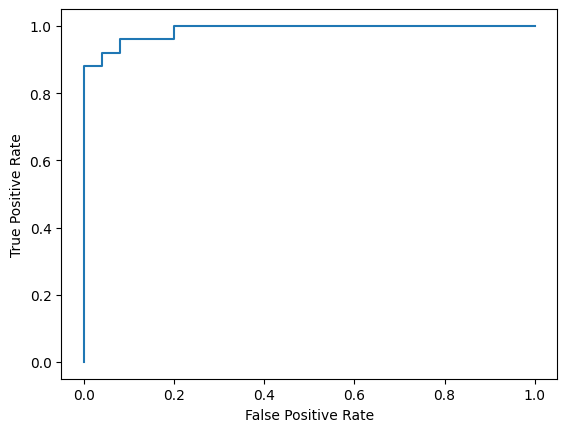


----------------------- 3. Logistic Regression -----------------------

Logistic Regression Accuracy: 98.0%
              precision    recall  f1-score   support

          -1       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

[[24  1]
 [ 0 25]]


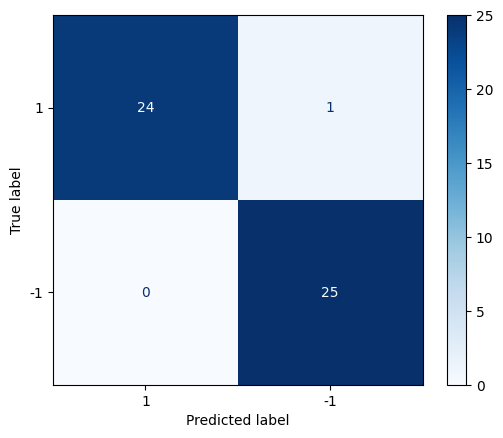

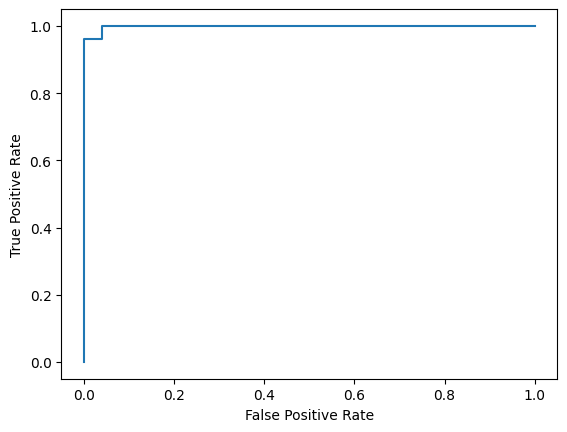


----------------------- 4. Multilayer Perceptron -----------------------

Multilayer Perceptron Accuracy: 96.0%
              precision    recall  f1-score   support

          -1       0.96      0.96      0.96        25
           1       0.96      0.96      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

[[24  1]
 [ 1 24]]


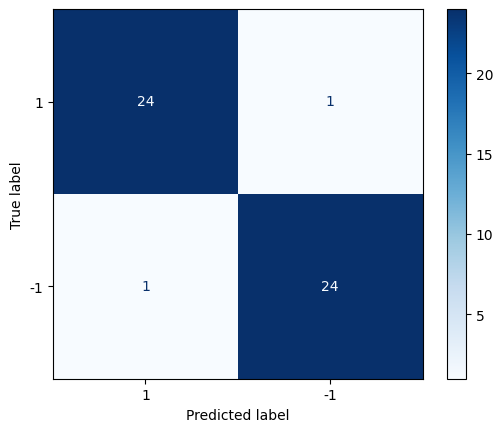

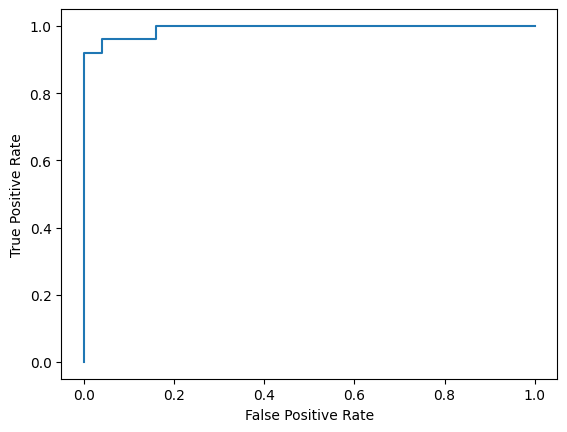


----------------------- 5. K-Nearest Neighbors -----------------------

K-Nearest Neighbors Accuracy: 94.0%
              precision    recall  f1-score   support

          -1       0.92      0.96      0.94        25
           1       0.96      0.92      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

[[24  1]
 [ 2 23]]


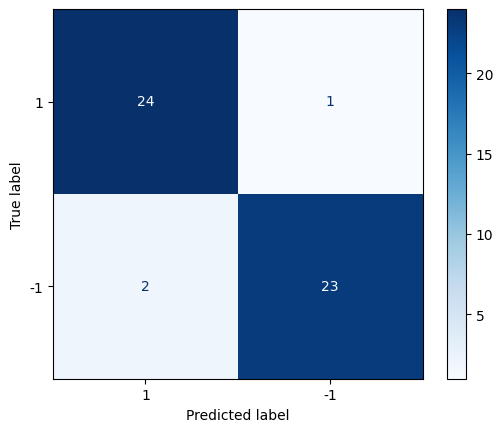

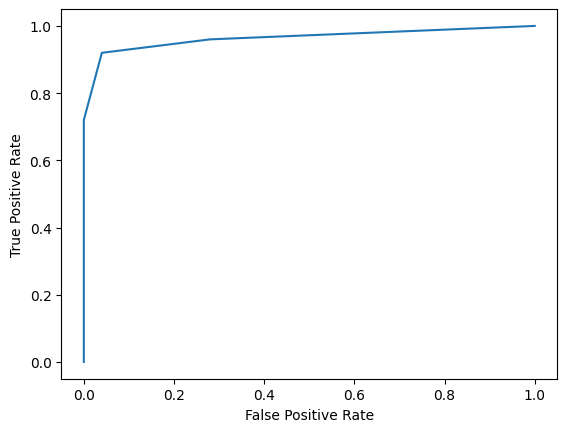

In [53]:
fit_classify(X_train, X_test, y_train, y_test, 5)

## Alternate Classifications

Other than the main classification that we did above, we will try out some differently pre-processes data, to see how classifiers trained on these data perform.

### 1. PCA / ICA Applied Before CSP

First only apply PCA before CSP and after CAR and segmentation.

Computing rank from data with rank=None
    Using tolerance 98 (2.2e-16 eps * 50 dim * 8.9e+15  max singular value)
    Estimated rank (data): 50
    data: rank 50 computed from 50 data channels with 0 projectors
Reducing data rank from 50 -> 50
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.

----------------------- 1. Support Vector Machine with Linear Kernel -----------------------

Support Vector Machine with Linear Kernel Accuracy: 94.0%
              precision    recall  f1-score   support

          -1       0.92      0.96      0.94        25
           1       0.96      0.92      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

[[24  1]
 [ 2 23]]


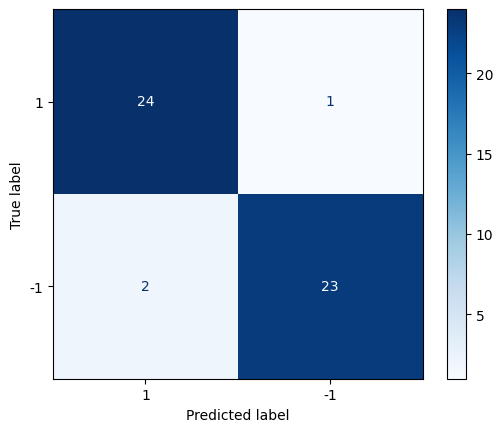

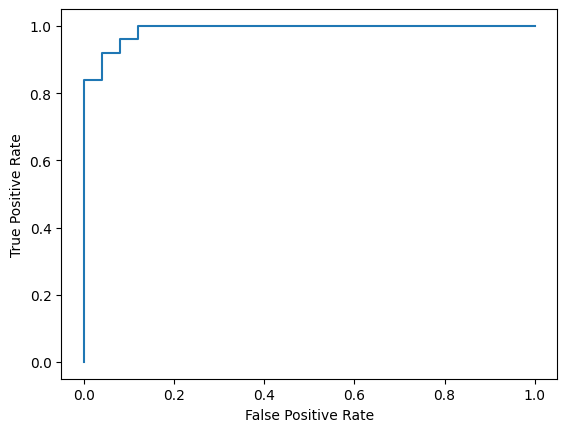


----------------------- 2. Support Vector Machine with RBF Kernel -----------------------

Support Vector Machine with RBF Kernel Accuracy: 88.0%
              precision    recall  f1-score   support

          -1       0.85      0.92      0.88        25
           1       0.91      0.84      0.87        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

[[23  2]
 [ 4 21]]


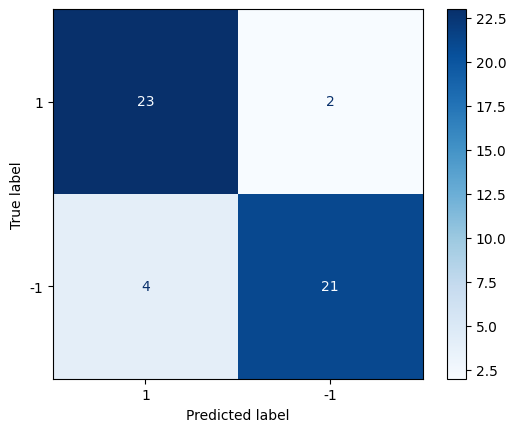

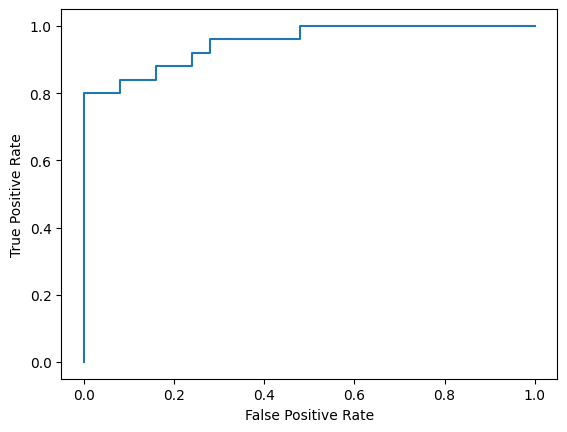


----------------------- 3. Logistic Regression -----------------------

Logistic Regression Accuracy: 94.0%
              precision    recall  f1-score   support

          -1       0.96      0.92      0.94        25
           1       0.92      0.96      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

[[23  2]
 [ 1 24]]


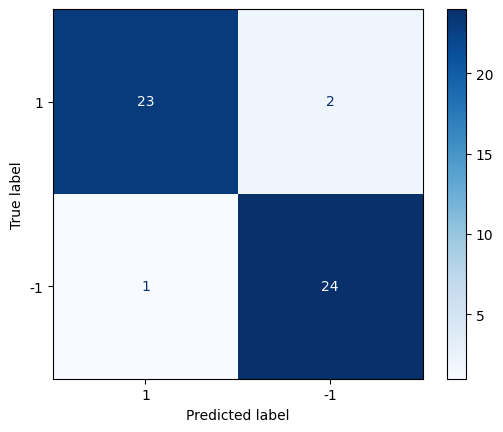

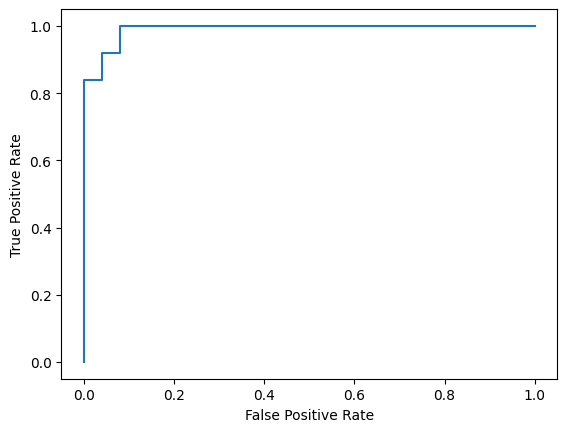


----------------------- 4. Multilayer Perceptron -----------------------

Multilayer Perceptron Accuracy: 92.0%
              precision    recall  f1-score   support

          -1       0.89      0.96      0.92        25
           1       0.96      0.88      0.92        25

    accuracy                           0.92        50
   macro avg       0.92      0.92      0.92        50
weighted avg       0.92      0.92      0.92        50

[[24  1]
 [ 3 22]]


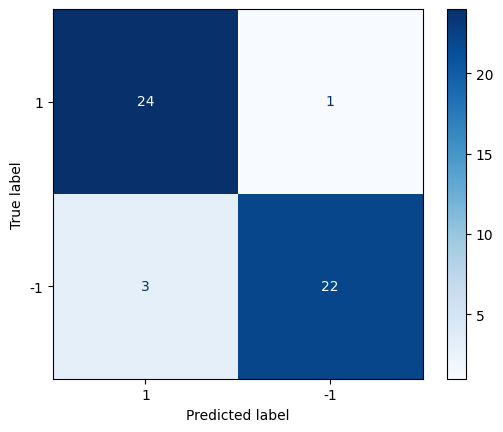

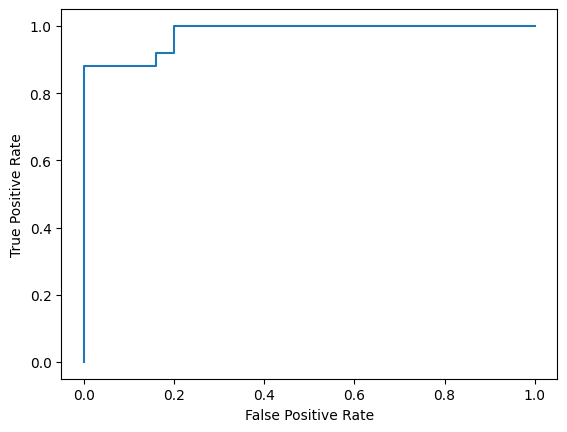


----------------------- 5. K-Nearest Neighbors -----------------------

K-Nearest Neighbors Accuracy: 86.0%
              precision    recall  f1-score   support

          -1       0.85      0.88      0.86        25
           1       0.88      0.84      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50

[[22  3]
 [ 4 21]]


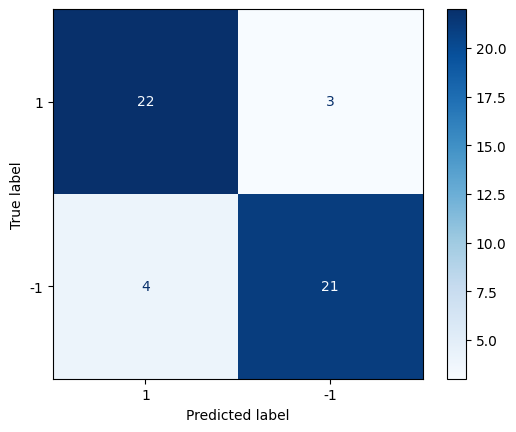

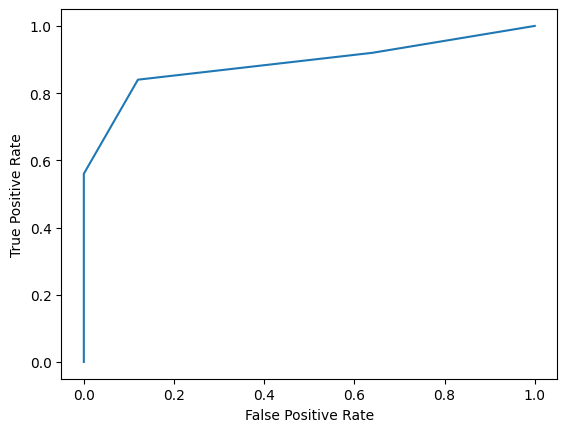

In [54]:
# Apply PCA
pca_data = principal_component_analysis(seg_data, 50)

# Apply CSP
csp_pca_data = common_spatial_patterns(pca_data, labels, 41)

# Perform classification
fit_classify(*train_test_normalize_split(csp_pca_data, labels), 5)

Now we only apply ICA.

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 0.011 (2.2e-16 eps * 50 dim * 1e+12  max singular value)
    Estimated rank (data): 50
    data: rank 50 computed from 50 data channels with 0 projectors
Reducing data rank from 50 -> 50
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.

----------------------- 1. Support Vector Machine with Linear Kernel -----------------------

Support Vector Machine with Linear Kernel Accuracy: 94.0%
              precision    recall  f1-score   support

          -1       0.92      0.96      0.94        25
           1       0.96      0.92      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

[[24  1]
 [ 2 23]]


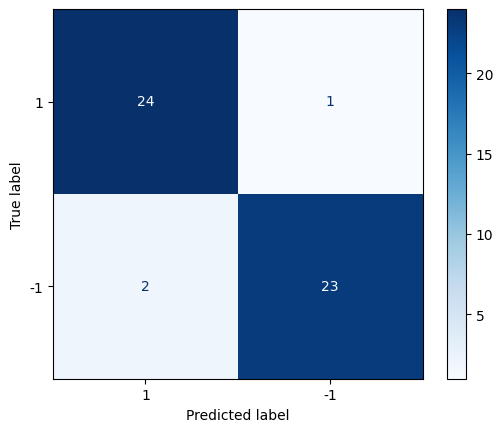

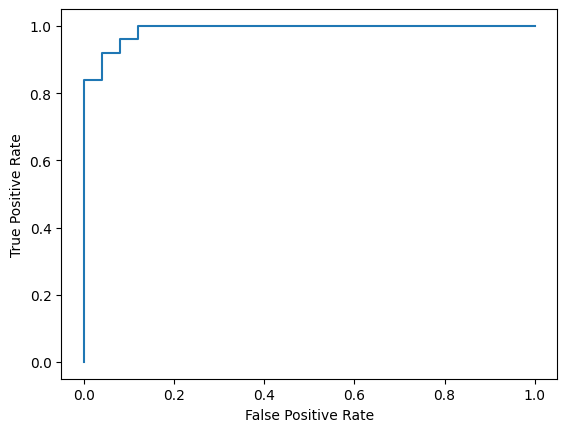


----------------------- 2. Support Vector Machine with RBF Kernel -----------------------

Support Vector Machine with RBF Kernel Accuracy: 88.0%
              precision    recall  f1-score   support

          -1       0.85      0.92      0.88        25
           1       0.91      0.84      0.87        25

    accuracy                           0.88        50
   macro avg       0.88      0.88      0.88        50
weighted avg       0.88      0.88      0.88        50

[[23  2]
 [ 4 21]]


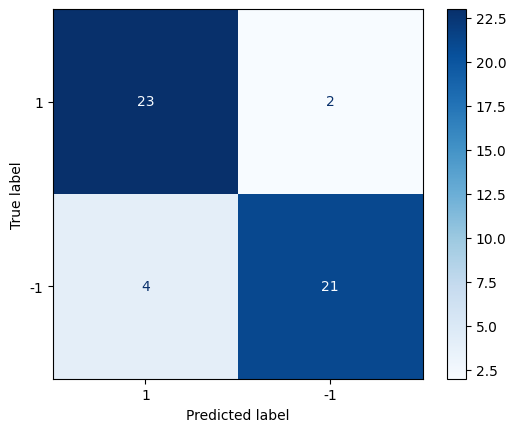

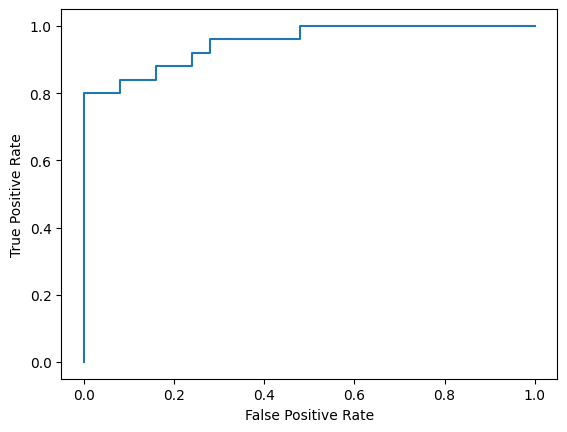


----------------------- 3. Logistic Regression -----------------------

Logistic Regression Accuracy: 94.0%
              precision    recall  f1-score   support

          -1       0.96      0.92      0.94        25
           1       0.92      0.96      0.94        25

    accuracy                           0.94        50
   macro avg       0.94      0.94      0.94        50
weighted avg       0.94      0.94      0.94        50

[[23  2]
 [ 1 24]]


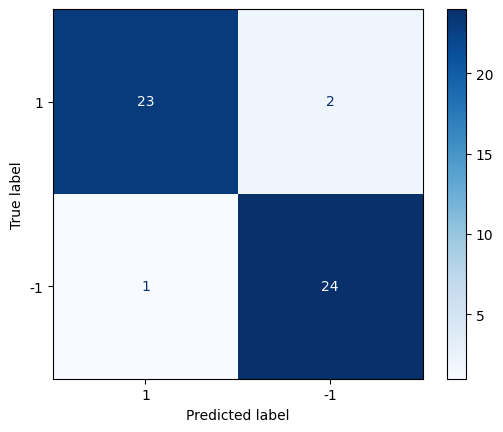

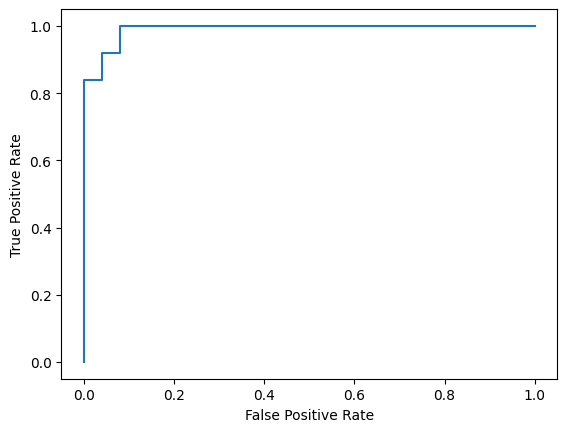


----------------------- 4. Multilayer Perceptron -----------------------

Multilayer Perceptron Accuracy: 90.0%
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

[[23  2]
 [ 3 22]]


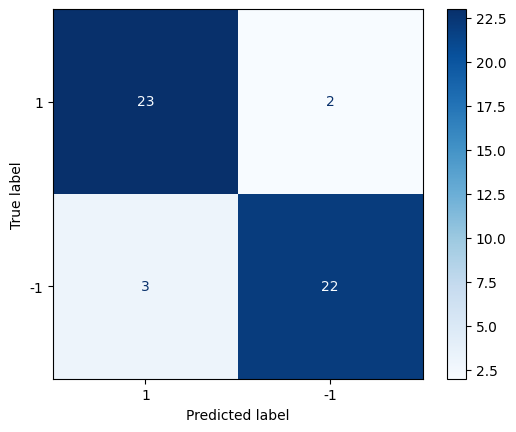

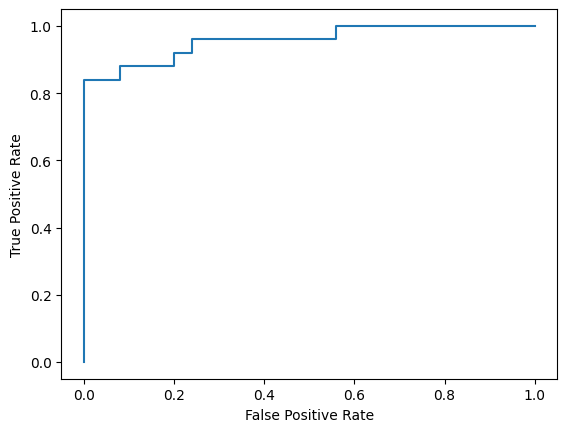


----------------------- 5. K-Nearest Neighbors -----------------------

K-Nearest Neighbors Accuracy: 86.0%
              precision    recall  f1-score   support

          -1       0.85      0.88      0.86        25
           1       0.88      0.84      0.86        25

    accuracy                           0.86        50
   macro avg       0.86      0.86      0.86        50
weighted avg       0.86      0.86      0.86        50

[[22  3]
 [ 4 21]]


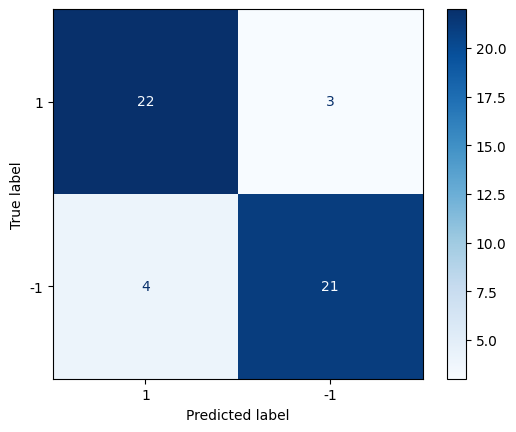

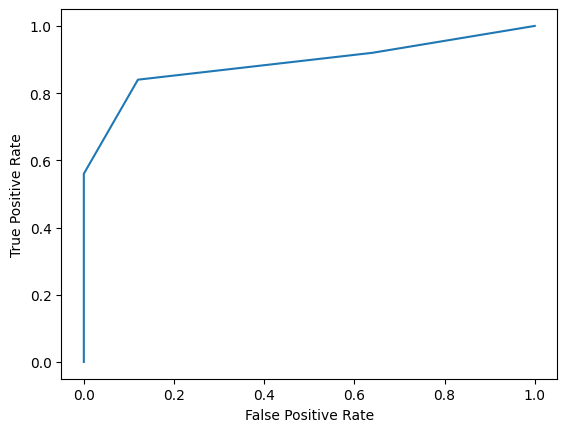

In [59]:
# Apply ICA
ica_data = independent_component_analysis(seg_data, 50)

# Apply CSP
csp_ica_data = common_spatial_patterns(ica_data, labels, 41)

# Perform classification
fit_classify(*train_test_normalize_split(csp_ica_data, labels), 5)

Now applying both, we have:

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:542: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Computing rank from data with rank=None
    Using tolerance 0.015 (2.2e-16 eps * 50 dim * 1.4e+12  max singular value)
    Estimated rank (data): 50
    data: rank 50 computed from 50 data channels with 0 projectors
Reducing data rank from 50 -> 50
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.

----------------------- 1. Support Vector Machine with Linear Kernel -----------------------

Support Vector Machine with Linear Kernel Accuracy: 94.0%
              precision    recall  f1-score   support

          -1       0.89      1.00      0.94        25
           1       1.00      0.88      0.94        25

    accuracy                           0.94        50
   macro avg       0.95      0.94      0.94        50
weighted avg       0.95      0.94      0.94        50

[[25  0]
 [ 3 22]]


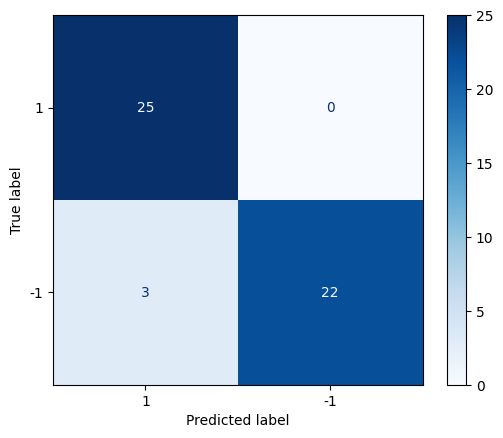

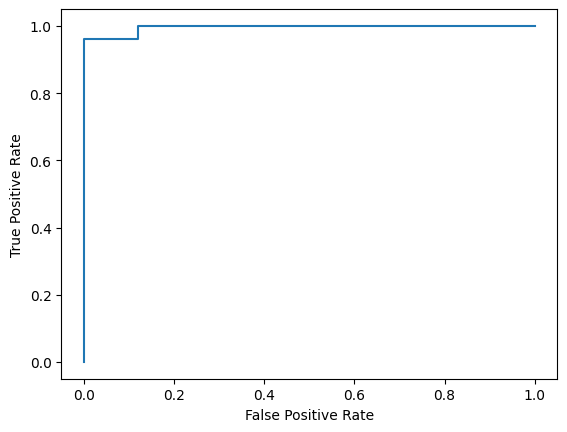


----------------------- 2. Support Vector Machine with RBF Kernel -----------------------

Support Vector Machine with RBF Kernel Accuracy: 90.0%
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

[[23  2]
 [ 3 22]]


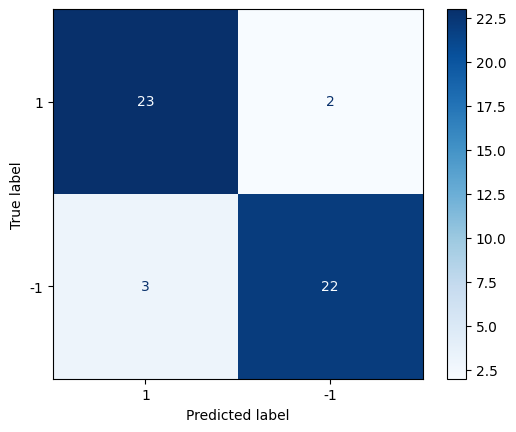

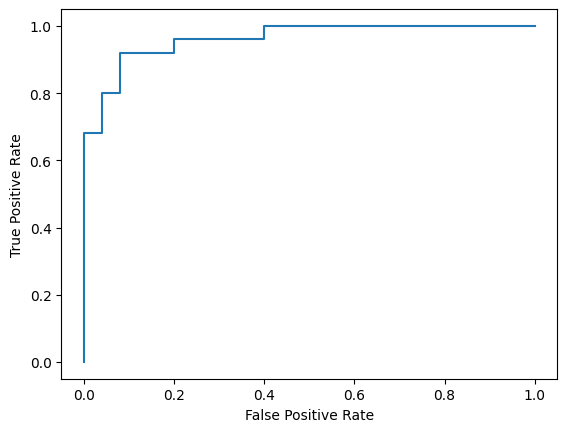


----------------------- 3. Logistic Regression -----------------------

Logistic Regression Accuracy: 96.0%
              precision    recall  f1-score   support

          -1       0.96      0.96      0.96        25
           1       0.96      0.96      0.96        25

    accuracy                           0.96        50
   macro avg       0.96      0.96      0.96        50
weighted avg       0.96      0.96      0.96        50

[[24  1]
 [ 1 24]]


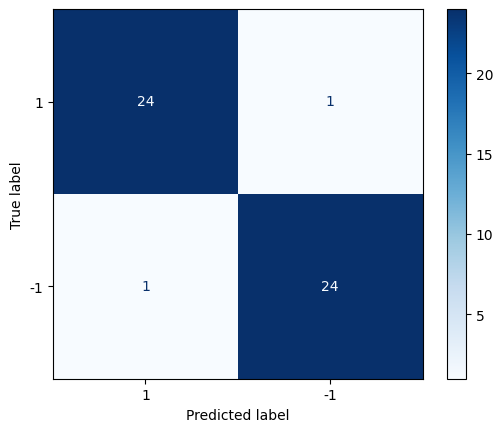

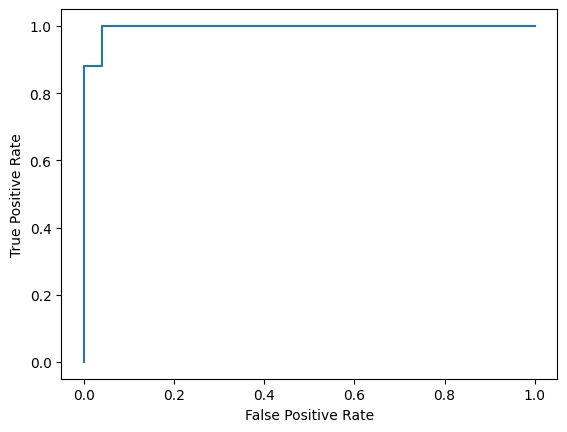


----------------------- 4. Multilayer Perceptron -----------------------

Multilayer Perceptron Accuracy: 90.0%
              precision    recall  f1-score   support

          -1       0.88      0.92      0.90        25
           1       0.92      0.88      0.90        25

    accuracy                           0.90        50
   macro avg       0.90      0.90      0.90        50
weighted avg       0.90      0.90      0.90        50

[[23  2]
 [ 3 22]]


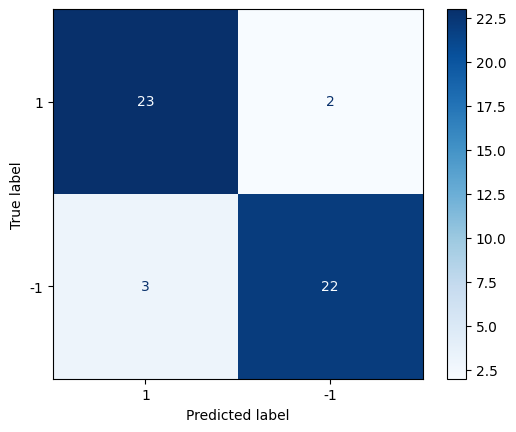

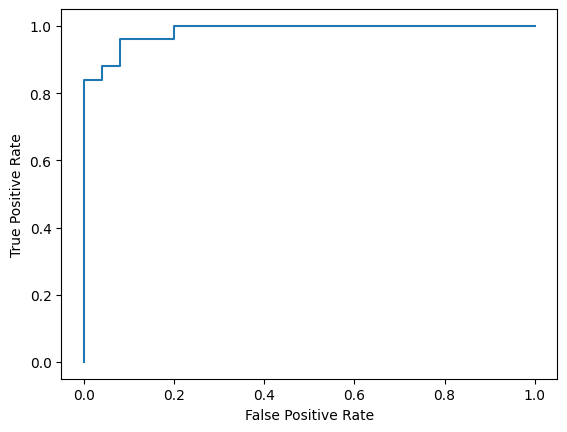


----------------------- 5. K-Nearest Neighbors -----------------------

K-Nearest Neighbors Accuracy: 82.0%
              precision    recall  f1-score   support

          -1       0.81      0.84      0.82        25
           1       0.83      0.80      0.82        25

    accuracy                           0.82        50
   macro avg       0.82      0.82      0.82        50
weighted avg       0.82      0.82      0.82        50

[[21  4]
 [ 5 20]]


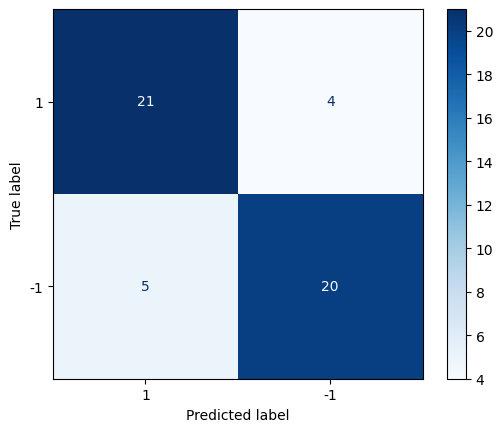

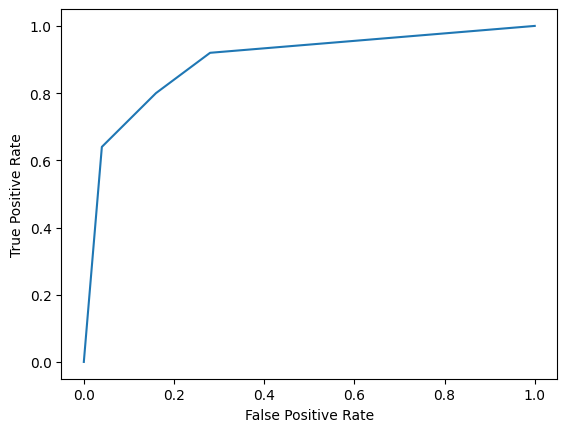

In [60]:
# Apply ICA
ica_data = independent_component_analysis(seg_data, 59)

# Apply PCA
pca_ica_data = principal_component_analysis(ica_data, 50)

# Apply CSP
csp_pca_ica_data = common_spatial_patterns(pca_ica_data, labels, 41)

# Perform classification
fit_classify(*train_test_normalize_split(csp_pca_ica_data, labels), 5)

### 2. Other Feature Extraction Methods

Now we use other feature extraction methods instead of CSP. We will use the FFT and CWT. First **FFT**:


----------------------- 1. Support Vector Machine with Linear Kernel -----------------------

Support Vector Machine with Linear Kernel Accuracy: 64.0%
              precision    recall  f1-score   support

          -1       0.68      0.52      0.59        25
           1       0.61      0.76      0.68        25

    accuracy                           0.64        50
   macro avg       0.65      0.64      0.63        50
weighted avg       0.65      0.64      0.63        50

[[13 12]
 [ 6 19]]


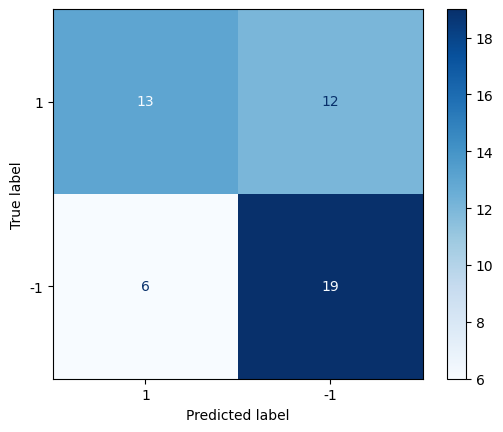

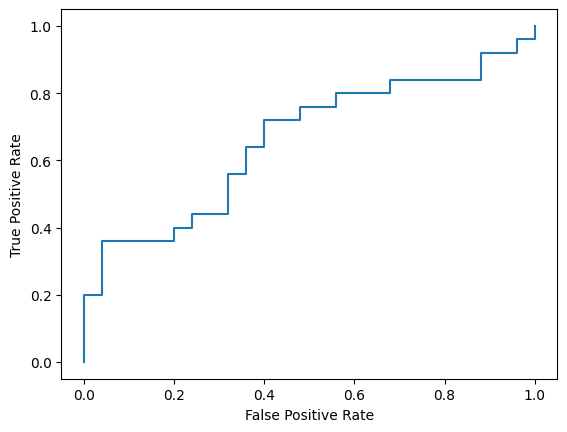


----------------------- 2. Support Vector Machine with RBF Kernel -----------------------

Support Vector Machine with RBF Kernel Accuracy: 57.99999999999999%
              precision    recall  f1-score   support

          -1       0.60      0.48      0.53        25
           1       0.57      0.68      0.62        25

    accuracy                           0.58        50
   macro avg       0.58      0.58      0.58        50
weighted avg       0.58      0.58      0.58        50

[[12 13]
 [ 8 17]]


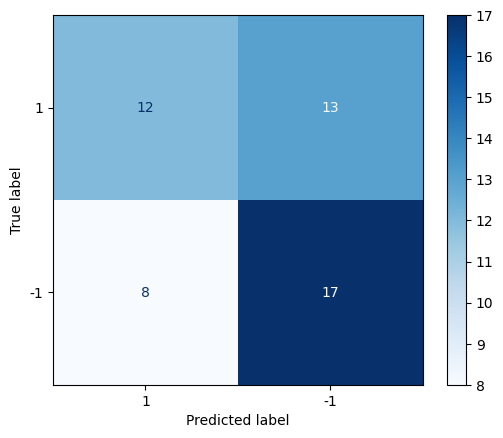

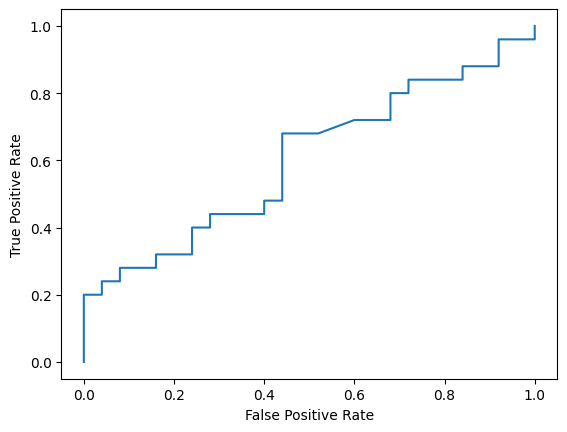


----------------------- 3. Logistic Regression -----------------------

Logistic Regression Accuracy: 60.0%
              precision    recall  f1-score   support

          -1       0.65      0.44      0.52        25
           1       0.58      0.76      0.66        25

    accuracy                           0.60        50
   macro avg       0.61      0.60      0.59        50
weighted avg       0.61      0.60      0.59        50

[[11 14]
 [ 6 19]]


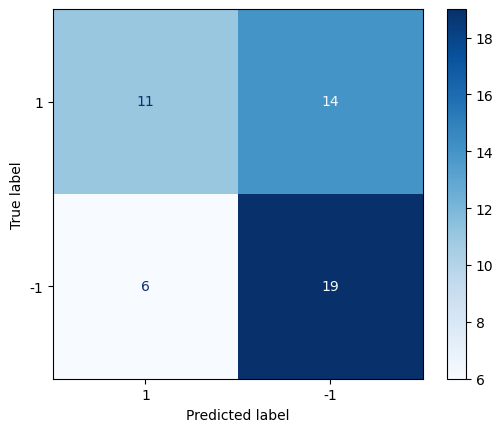

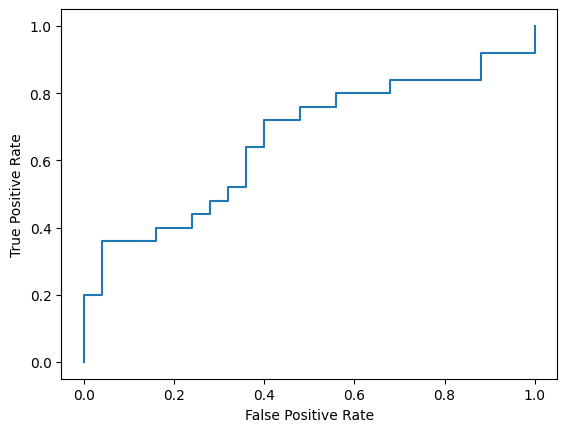


----------------------- 4. Multilayer Perceptron -----------------------

Multilayer Perceptron Accuracy: 60.0%
              precision    recall  f1-score   support

          -1       0.59      0.68      0.63        25
           1       0.62      0.52      0.57        25

    accuracy                           0.60        50
   macro avg       0.60      0.60      0.60        50
weighted avg       0.60      0.60      0.60        50

[[17  8]
 [12 13]]


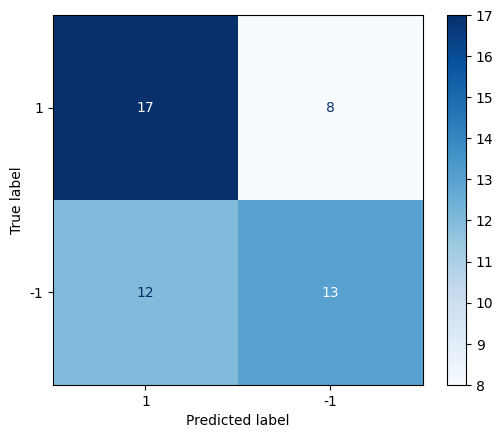

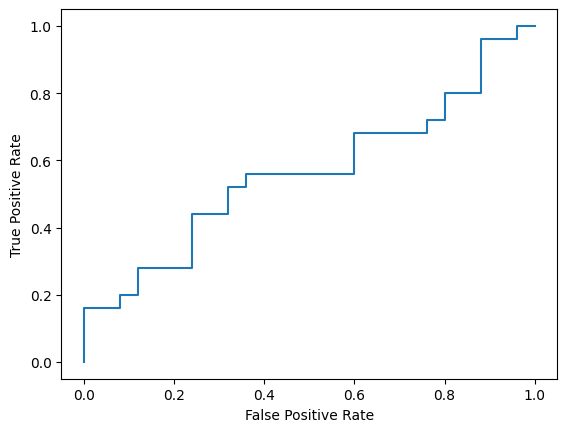


----------------------- 5. K-Nearest Neighbors -----------------------

K-Nearest Neighbors Accuracy: 48.0%
              precision    recall  f1-score   support

          -1       0.49      0.68      0.57        25
           1       0.47      0.28      0.35        25

    accuracy                           0.48        50
   macro avg       0.48      0.48      0.46        50
weighted avg       0.48      0.48      0.46        50

[[17  8]
 [18  7]]


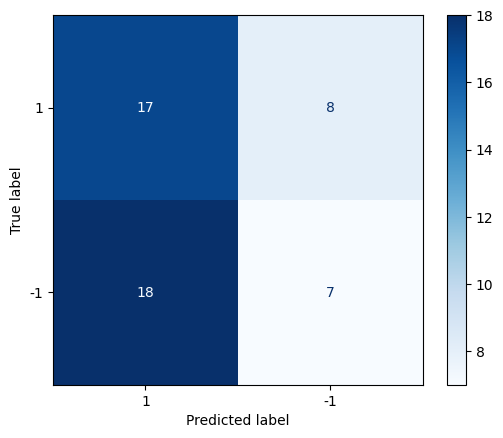

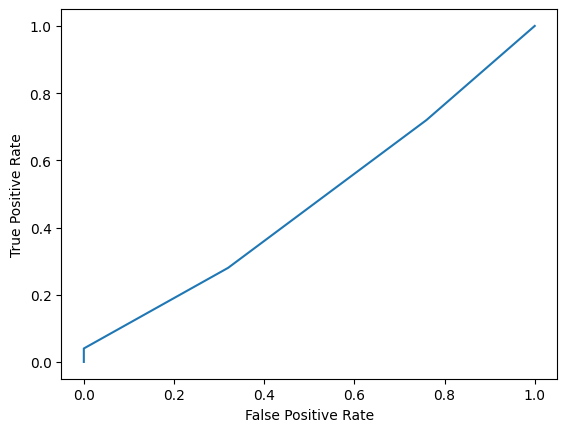

In [61]:
# Use the FF transformed data to perform classification
fit_classify(*train_test_normalize_split(fft_data, labels), 5)

Now **CWT**:


----------------------- 1. Support Vector Machine with Linear Kernel -----------------------

Support Vector Machine with Linear Kernel Accuracy: 57.99999999999999%
              precision    recall  f1-score   support

          -1       0.58      0.60      0.59        25
           1       0.58      0.56      0.57        25

    accuracy                           0.58        50
   macro avg       0.58      0.58      0.58        50
weighted avg       0.58      0.58      0.58        50

[[15 10]
 [11 14]]


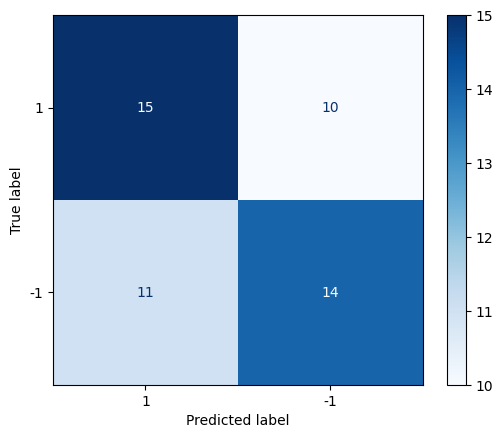

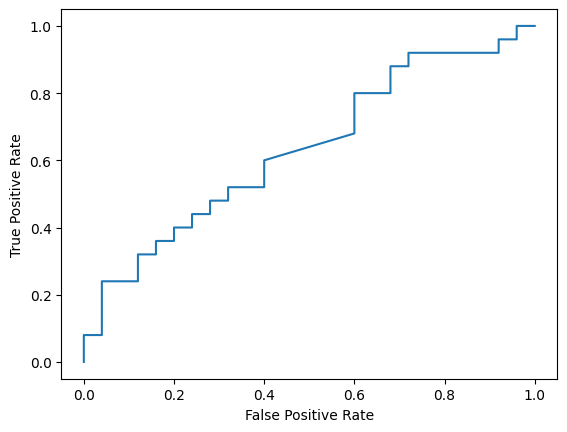


----------------------- 2. Support Vector Machine with RBF Kernel -----------------------

Support Vector Machine with RBF Kernel Accuracy: 62.0%
              precision    recall  f1-score   support

          -1       0.65      0.52      0.58        25
           1       0.60      0.72      0.65        25

    accuracy                           0.62        50
   macro avg       0.62      0.62      0.62        50
weighted avg       0.62      0.62      0.62        50

[[13 12]
 [ 7 18]]


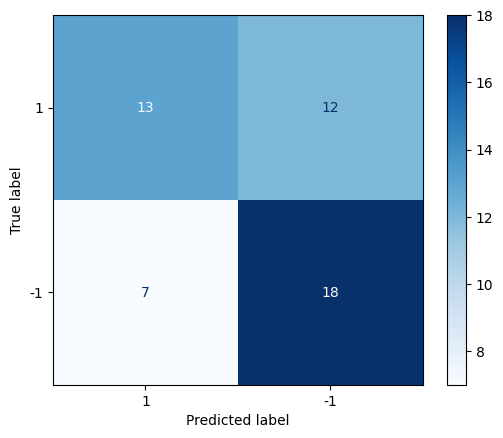

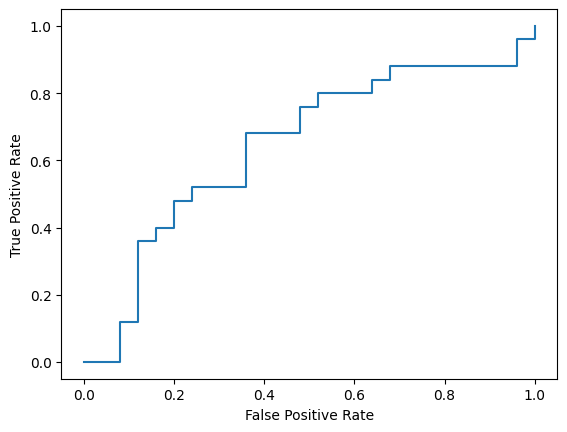

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



----------------------- 3. Logistic Regression -----------------------

Logistic Regression Accuracy: 54.0%
              precision    recall  f1-score   support

          -1       0.54      0.52      0.53        25
           1       0.54      0.56      0.55        25

    accuracy                           0.54        50
   macro avg       0.54      0.54      0.54        50
weighted avg       0.54      0.54      0.54        50

[[13 12]
 [11 14]]


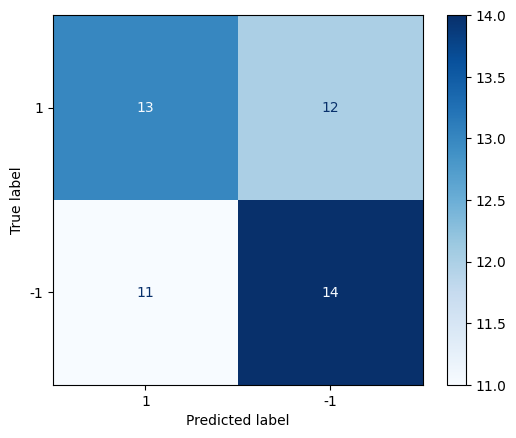

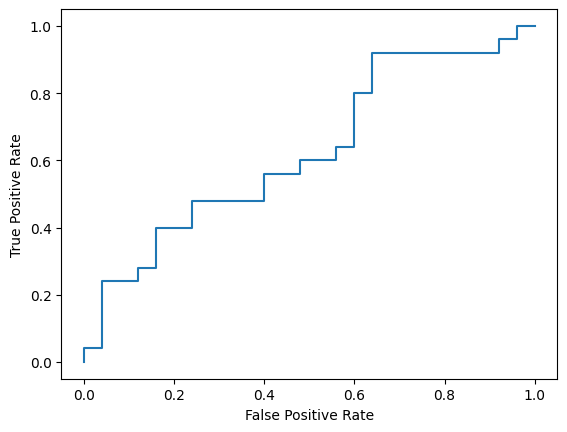


----------------------- 4. Multilayer Perceptron -----------------------

Multilayer Perceptron Accuracy: 56.00000000000001%
              precision    recall  f1-score   support

          -1       0.56      0.56      0.56        25
           1       0.56      0.56      0.56        25

    accuracy                           0.56        50
   macro avg       0.56      0.56      0.56        50
weighted avg       0.56      0.56      0.56        50

[[14 11]
 [11 14]]


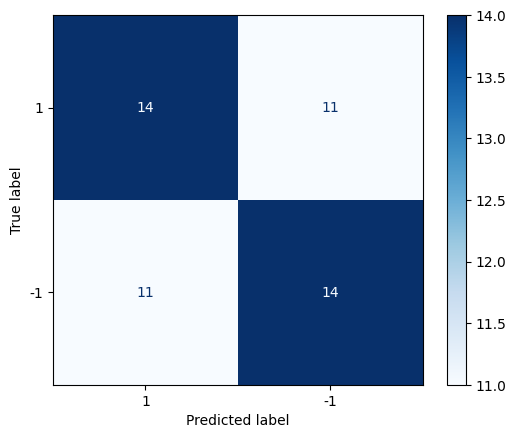

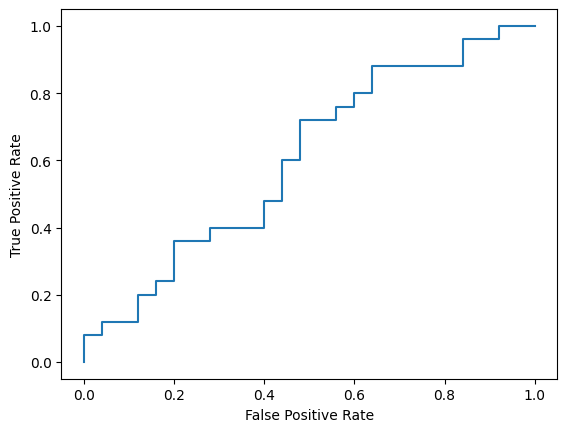


----------------------- 5. K-Nearest Neighbors -----------------------

K-Nearest Neighbors Accuracy: 56.00000000000001%
              precision    recall  f1-score   support

          -1       0.55      0.68      0.61        25
           1       0.58      0.44      0.50        25

    accuracy                           0.56        50
   macro avg       0.56      0.56      0.55        50
weighted avg       0.56      0.56      0.55        50

[[17  8]
 [14 11]]


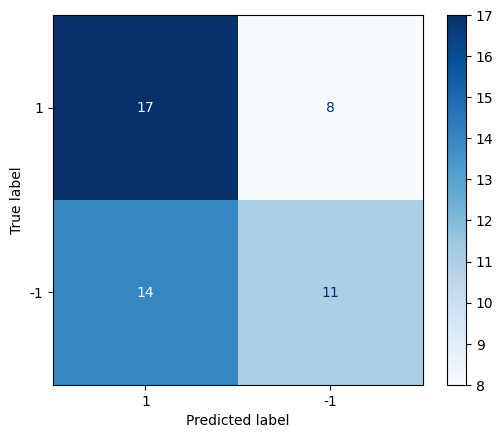

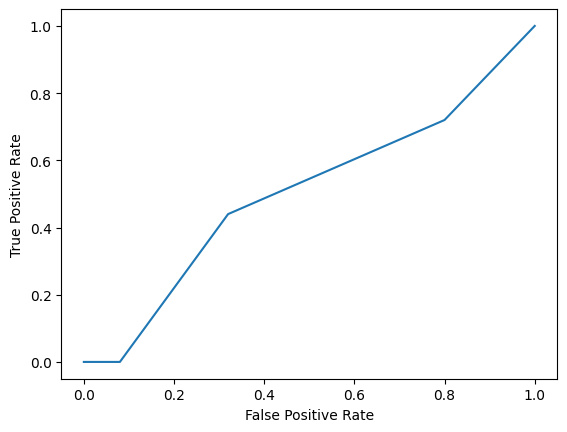

In [62]:
# Use the CW transformed data to perform classification
fit_classify(*train_test_normalize_split(cwt_data, labels), 5)

As we can see, both methods lead to way worse performance from the classifiers, CWT slightly more so.

As we can see, for this dataset, there is even better separation between the two classes in the features. Thus, we can expect better classification performance for this dataset.

## Clustering

### KMeans

In [ ]:
def k_means(data):
    # Initialize variables
    silhouette_scores = []
    range_n_clusters = range(2, 10)  

    # Iterate over different numbers of clusters
    for n_clusters in range_n_clusters:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        pred = kmeans.fit_predict(data)
        silhouette_avg = silhouette_score(data, pred)
        silhouette_scores.append(silhouette_avg)
        print(f'Number of clusters: {n_clusters},\
            Silhouette Score: {silhouette_avg}')

    # Plot the silhouette scores
    plt.figure(figsize=(8, 4))
    plt.plot(range_n_clusters, silhouette_scores, marker='o')
    plt.title("Silhouette Scores for different numbers of clusters")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()

    # Determine the optimal number of clusters
    optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
    print(f'Optimal number of clusters according to \
        silhouette score: {optimal_n_clusters}')

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 2,            Silhouette Score: 0.7172523888216132
Number of clusters: 3,            Silhouette Score: 0.21463600605207214
Number of clusters: 4,            Silhouette Score: 0.21786386190867382
Number of clusters: 5,            Silhouette Score: 0.18468241781882203
Number of clusters: 6,            Silhouette Score: 0.18168923007889673


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 7,            Silhouette Score: 0.15687462807106325
Number of clusters: 8,            Silhouette Score: 0.15255800780994325
Number of clusters: 9,            Silhouette Score: 0.13455301788470364


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


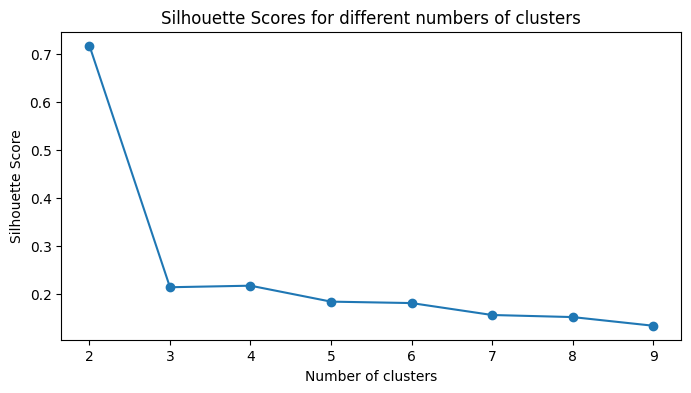

Optimal number of clusters according to         silhouette score: 2


In [64]:
# Perform K-means
k_means(csp_data)

In [69]:
def specific_kmeans(data, labels, number_clusters=2):
    '''Function for more detailed run of kmeans using a specific cluster number'''
    #Create a k-means model with specific number of clusters
    kmeans = KMeans(n_clusters=number_clusters, init='k-means++', max_iter=300, \
                    random_state=42)

    #Fit for kmeans clustering
    kmeans.fit(data)

    #Get labels
    pred_labels_kmeans = kmeans.labels_

    #Get Centroids 
    centroids_kmeans = kmeans.cluster_centers_

    print("Center(centroid) of clusters in KMEANS method  with \
        $n_clusters={}$ are as follows:\n\n".format(number_clusters),\
              centroids_kmeans)
    print("*"*90)
    print("Predicted labels in KMEANS method with $n_clusters={}$ \
        are as follows:\n".format(number_clusters))
    print(pred_labels_kmeans)
    print("*"*90)

    # Homogeneity
    homogeneity_kmeans = homogeneity_score(labels_true=labels,\
                                           labels_pred= pred_labels_kmeans)
    print("Homogeneity score of KMEANS method with {0} clusters \
        is: ".format(number_clusters),homogeneity_kmeans)

    # Silhouette
    silhouette_score_kmeans = silhouette_score(data,pred_labels_kmeans)
    print("Silhouette score of KMEANS method with {0} clusters\
        is:  ".format(number_clusters),silhouette_score_kmeans)

In [70]:
# K-means with 2 clusters
specific_kmeans(csp_data, labels, number_clusters=2)

Center(centroid) of clusters in KMEANS method  with         $n_clusters=2$ are as follows:

 [[-3.27725930e+00 -1.90373313e+00 -1.94911225e+00 -1.36308531e+00
  -9.40392297e-01 -8.66853376e-01 -9.47339447e-01 -1.13460970e+00
  -8.84849981e-01 -9.05080053e-01 -9.22389796e-01 -1.01613951e+00
  -8.68779574e-01 -8.81280059e-01 -1.15845570e+00 -7.93682645e-01
  -8.84401085e-01 -8.23932725e-01 -7.64689271e-01 -9.63540751e-01
  -8.45344660e-01 -8.62032852e-01 -9.23356352e-01 -7.78747427e-01
  -7.41787461e-01 -7.57983677e-01 -7.61646858e-01 -7.52551263e-01
  -8.11597606e-01 -7.35116926e-01 -7.41708340e-01 -7.19193697e-01
  -7.76870570e-01 -7.28201662e-01 -7.82445859e-01 -7.27438599e-01
  -7.22581501e-01 -7.63505746e-01 -7.44843119e-01 -7.44248054e-01
  -7.28560522e-01]
 [ 8.16183520e-01  1.06659483e+00  1.26341836e+00  1.04004485e+00
   1.76729953e-01  1.90232195e-03  4.00139745e-01  1.16534053e+00
  -6.78462719e-01  5.37941758e-01  5.62423595e-01  9.02181694e-01
  -7.23112912e-01  5.50480324e

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [71]:
# K-means with 5 clusters
specific_kmeans(csp_data, labels, number_clusters=5)

Center(centroid) of clusters in KMEANS method  with         $n_clusters=5$ are as follows:

 [[-3.3939851  -2.03697395 -2.10339745 -1.62673088 -1.39074535 -1.25339864
  -1.23023631 -1.32233284 -1.37316005 -1.11239729 -1.15302168 -1.21822099
  -1.33270972 -1.11887912 -1.31818961 -1.00001323 -1.06291831 -0.99204387
  -0.73436717 -1.09030467 -0.94982356 -1.00523311 -1.06952465 -0.88731507
  -0.72086403 -0.87632714 -0.82940672 -0.90838644 -0.87964034 -0.78526113
  -0.84254387 -0.79120576 -0.83347031 -0.82217871 -0.88215006 -0.79035504
  -0.72927498 -0.82015788 -0.78421137 -0.80048676 -0.79507642]
 [ 1.4474898   1.53045712  1.59909261  1.42172213  0.41274902  0.19945633
   0.65868349  1.28472679 -0.69185609  0.69103826  0.7047341   1.03551028
  -0.75920854  0.6206077   1.27687931  0.09938502  0.61268198  0.30658883
  -0.59822137  0.77370446  0.49701299  0.575377    0.80479185  0.17674625
  -0.22250158 -0.02886307 -0.04806632 -0.16847982  0.35947517 -0.24157439
  -0.23838421 -0.48431738  0.0

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [72]:
# K-means with 9 clusters
specific_kmeans(csp_data, labels, number_clusters=9)

Center(centroid) of clusters in KMEANS method  with         $n_clusters=9$ are as follows:

 [[-3.16896271 -1.81851537 -1.88447792 -1.05354717 -0.28134731 -0.36703212
  -0.62714272 -0.93990806 -0.50837567 -0.60041325 -0.67231385 -0.81515842
  -0.41171453 -0.5569503  -0.96673886 -0.52457648 -0.66685255 -0.61623105
  -0.84150378 -0.78776577 -0.76249568 -0.71150206 -0.78684843 -0.64182234
  -0.76492195 -0.57562449 -0.71570621 -0.5437577  -0.77053597 -0.70232717
  -0.57019193 -0.65641414 -0.6917244  -0.61273256 -0.64497795 -0.57659544
  -0.72662662 -0.71828142 -0.7250814  -0.65849882 -0.64505911]
 [ 1.05938513  1.2546538   1.31454728  1.19174761  0.26213452  0.02105127
   0.4470125   1.16523962 -0.64497744  0.53544719  0.53060253  0.90041967
  -0.71742216  0.51270064  1.17431312 -0.04627809  0.49953088  0.23278268
  -0.67657684  0.58848987  0.36630643  0.48291527  0.69110423  0.11796597
  -0.24687087 -0.09909972 -0.08435062 -0.22780219  0.2924911  -0.24763092
  -0.26895647 -0.51312571  0.0

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### DBScan

In [73]:
def db_scan(data, labels):
    #Create DBSCAN model for clustering
    eps_ = 3
    min_samples_ = 6

    #dbscan = DBSCAN(eps=2, min_samples=6, metric='chebyshev')
    dbscan = DBSCAN(eps=eps_, min_samples=min_samples_, metric='euclidean')

    #Fit for dbscan clustering
    dbscan.fit(data)

    #Get labels and number of clusters
    pred_labels_dbscan = dbscan.labels_
    number_clusters_dbscan = len(np.unique(pred_labels_dbscan)) - 1

    print("Number of clusters in DBScan method with $eps={0},\
    min_samples={1}$ is:".format(eps_,min_samples_),number_clusters_dbscan)
    print("Predicted labels in DBScan method with $eps={0},\
    min_samples={1}$ are as follows:\n".format(eps_,min_samples_))
    print(pred_labels_dbscan)
    print("*"*90)

    # Homogeneity
    homogeneity_dbscan = homogeneity_score(labels_true=labels, \
                                           labels_pred= pred_labels_dbscan)
    print("Homogeneity score of DBScan method with with $eps={0},\
        min_samples={1}$ is: ".format(eps_,min_samples_),homogeneity_dbscan)

    # Silhouette
    silhouette_score_dbscan = silhouette_score(data,pred_labels_dbscan)
    print("Silhouette score of DBScan method with with $eps={0},\
        min_samples={1}$ is: ".format(eps_,min_samples_),silhouette_score_dbscan)

In [74]:
# Perform DBScan
db_scan(csp_data, labels)

Number of clusters in DBScan method with $eps=3,    min_samples=6$ is: 2
Predicted labels in DBScan method with $eps=3,    min_samples=6$ are as follows:

[ 0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  1  0  0  0  0  0  0  0]
******************************************************************************************
Homogeneity score of DBScan method with with $eps=3,        min_samples=6$ is:  0.002526266704011455
Silhouette score of DBScan method with with

### GMM

In [77]:
def best_gmm(data):
    # AIC and BIC analysis for finding the best number of components to cluster datapoints!
    n_components = np.arange(2, 10)
    models = [GaussianMixture(n, random_state=42).fit(data) for n in n_components]
    bics = [model.bic(data) for model in models]
    aics = [model.aic(data) for model in models]

    plt.plot(n_components, bics, label='BIC')
    plt.plot(n_components, aics, label='AIC')
    plt.legend(loc='best')
    plt.xlabel('Number of components')
    plt.ylabel('BIC/AIC')
    plt.title('BIC and AIC for GMM')
    plt.show()

    optimal_n_components = n_components[np.argmin(bics)]
    print("Optimal number of components according to BIC:", optimal_n_components)

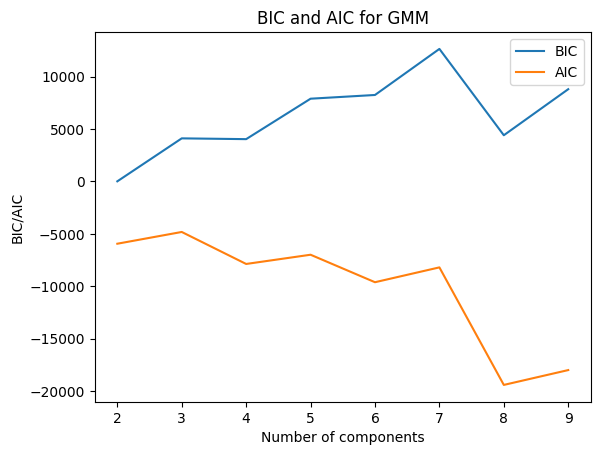

Optimal number of components according to BIC: 2


In [78]:
best_gmm(csp_data)

In [79]:
def optimal_gmm(data):
    # Initialize variables
    silhouette_scores = []
    range_n_components = range(2, 10)  # You can adjust this range based on your requirements

    # Iterate over different numbers of components
    for n_components in range_n_components:
        gmm = GaussianMixture(n_components=n_components, random_state=42)
        pred_labels = gmm.fit_predict(data)
        silhouette_avg = silhouette_score(data, pred_labels)
        silhouette_scores.append(silhouette_avg)
        print(f'Number of components: {n_components}, Silhouette Score: {silhouette_avg}')

    # Plot the silhouette scores
    plt.figure(figsize=(8, 4))
    plt.plot(range_n_components, silhouette_scores, marker='o')
    plt.title("Silhouette Scores for different numbers of components")
    plt.xlabel("Number of components")
    plt.ylabel("Silhouette Score")
    plt.show()

    # Determine the optimal number of components
    optimal_n_components = range_n_components[np.argmax(silhouette_scores)]
    print(f'Optimal number of components according to silhouette score: {optimal_n_components}')

Number of components: 2, Silhouette Score: 0.7172523888216132
Number of components: 3, Silhouette Score: 0.20869078960636828
Number of components: 4, Silhouette Score: 0.20817732815364312
Number of components: 5, Silhouette Score: 0.16319813934014551
Number of components: 6, Silhouette Score: 0.1582040950671274
Number of components: 7, Silhouette Score: 0.15396143704859674
Number of components: 8, Silhouette Score: 0.11185761213787357
Number of components: 9, Silhouette Score: 0.10916780681724207


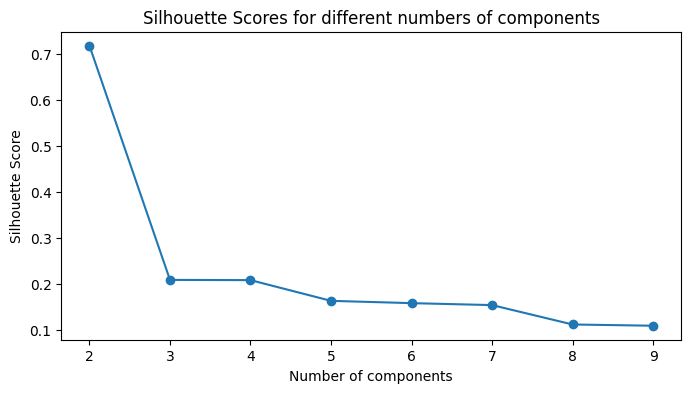

Optimal number of components according to silhouette score: 2


In [80]:
# Find optimal number of components
optimal_gmm(csp_data)

In [83]:
# Apply Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(csp_data)
pred_labels_gmm = gmm.predict(csp_data)

In [84]:
# Print the means of the Gaussian components
print("Means of the Gaussian components:\n", gmm.means_)
print("*"*90)
# Print the covariances of the Gaussian components
print("Covariances of the Gaussian components:\n", gmm.covariances_)

Means of the Gaussian components:
 [[-3.27725930e+00 -1.90373313e+00 -1.94911225e+00 -1.36308531e+00
  -9.40392297e-01 -8.66853376e-01 -9.47339447e-01 -1.13460970e+00
  -8.84849981e-01 -9.05080053e-01 -9.22389796e-01 -1.01613951e+00
  -8.68779574e-01 -8.81280059e-01 -1.15845570e+00 -7.93682645e-01
  -8.84401085e-01 -8.23932725e-01 -7.64689271e-01 -9.63540751e-01
  -8.45344660e-01 -8.62032852e-01 -9.23356352e-01 -7.78747427e-01
  -7.41787461e-01 -7.57983677e-01 -7.61646858e-01 -7.52551263e-01
  -8.11597606e-01 -7.35116926e-01 -7.41708340e-01 -7.19193697e-01
  -7.76870570e-01 -7.28201662e-01 -7.82445859e-01 -7.27438599e-01
  -7.22581501e-01 -7.63505746e-01 -7.44843119e-01 -7.44248054e-01
  -7.28560522e-01]
 [ 8.16183520e-01  1.06659483e+00  1.26341836e+00  1.04004485e+00
   1.76729953e-01  1.90232195e-03  4.00139745e-01  1.16534053e+00
  -6.78462719e-01  5.37941758e-01  5.62423595e-01  9.02181694e-01
  -7.23112912e-01  5.50480324e-01  1.16896376e+00  9.27524867e-03
   5.01970777e-01  2.6

In [86]:
def apply_gmm(data, labels, n_comp=2):
    gmm = GaussianMixture(n_components=n_comp, random_state=42)
    pred_labels_gmm = gmm.fit_predict(data)

    silhouette_gmm = silhouette_score(data, pred_labels_gmm)
    homogeneity_gmm = homogeneity_score(labels_true=labels, labels_pred= pred_labels_gmm)

    print(f'Number of components: {n_comp}, Silhouette Score: {silhouette_gmm}')
    print(f'Number of components: {n_comp}, Homogeneity Score: {homogeneity_gmm}')

In [87]:
# GMM with 2 components
apply_gmm(csp_data, labels)

Number of components: 2, Silhouette Score: 0.7172523888216132
Number of components: 2, Homogeneity Score: 0.0015284029975106007


In [88]:
# GMM with 5 components
apply_gmm(csp_data, labels, 5)

Number of components: 5, Silhouette Score: 0.16319813934014551
Number of components: 5, Homogeneity Score: 0.29110627071035255


In [89]:
# GMM with 9 components
apply_gmm(csp_data, labels, 9)

Number of components: 9, Silhouette Score: 0.10916780681724207
Number of components: 9, Homogeneity Score: 0.3696426590343457


## Alternate Dataset

Now we will perform all the steps we have done before on an alternate dataset with different classes and observe the difference in model performances between the two datasets. For consiceness, we will only apply the methods that produced best results for the previous dataset on this dataset.

In [90]:
# Load .mat file containing the EEG signals
mat_alt = scipy.io.loadmat("/kaggle/input/bciciv-calib-ds1c/BCICIV_calib_ds1c.mat")
print("Variables include: ", mat_alt.keys())

# Extract variables
cnt_alt = mat_alt['cnt'].astype(np.float64) * 0.1  # Converted microvolts
pos_alt = mat_alt['mrk']['pos'][0][0].flatten()
y_alt = mat_alt['mrk']['y'][0][0].flatten()

# Extract extra info
nfo_alt = mat_alt['nfo']
fs_alt = nfo_alt['fs'][0][0][0][0]
clab_alt = [str(c[0]) for c in nfo_alt['clab'][0][0][0]]
classes_alt = [str(c[0]) for c in nfo_alt['classes'][0][0][0]]
xpos_alt = nfo_alt['xpos'][0][0][0]
ypos_alt = nfo_alt['ypos'][0][0][0]

# Log
print(f"Number of time samples: {cnt_alt.shape[0]}, Number of channels: {cnt_alt.shape[1]}")
print(f"The list of classes is {classes_alt}")

Variables include:  dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'cnt', 'nfo'])
Number of time samples: 190549, Number of channels: 59
The list of classes is ['left', 'right']


This dataset instead has the two classes of moving left or right hands.

Creating RawArray with float64 data, n_channels=59, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.


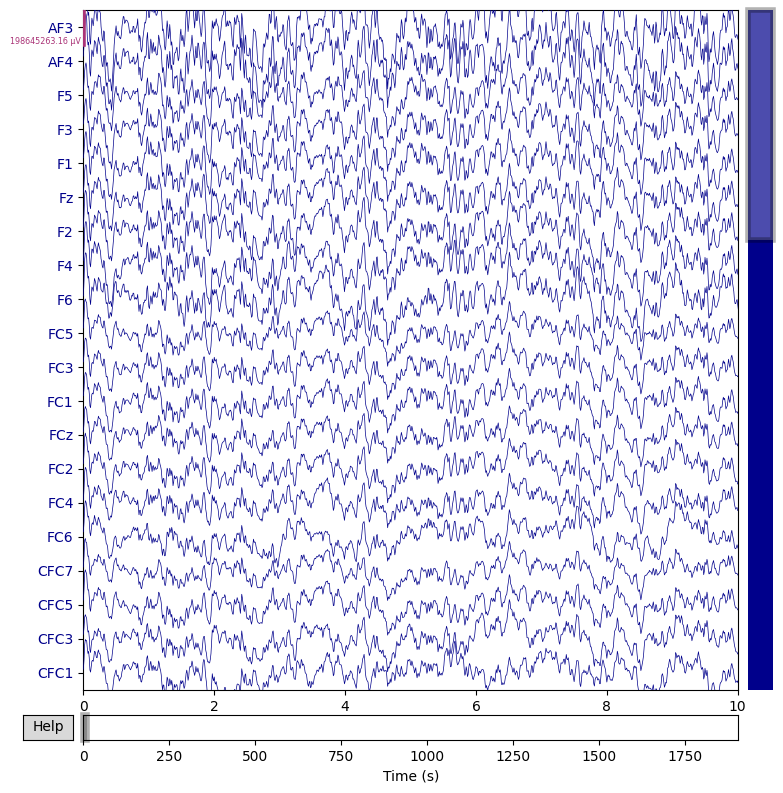

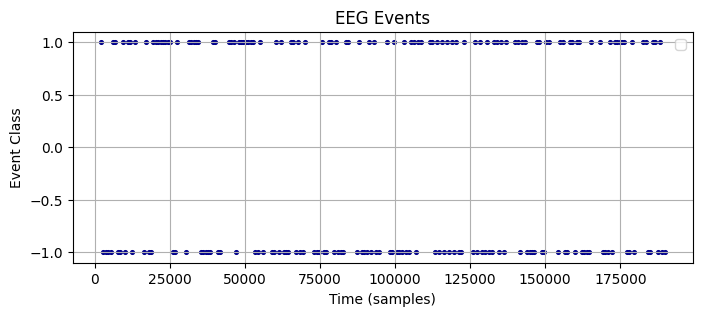

Creating RawArray with float64 data, n_channels=59, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.


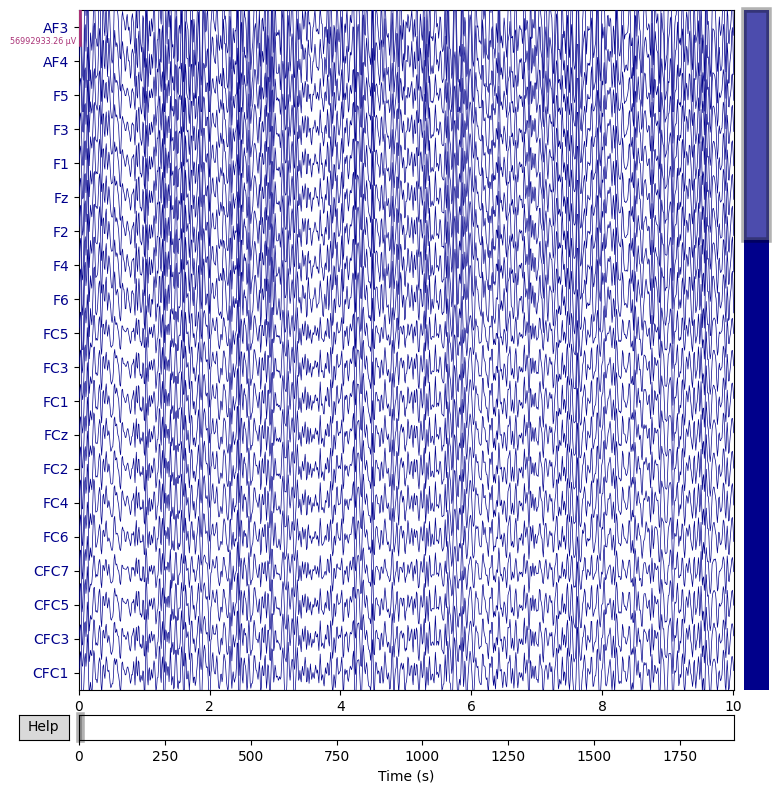

Creating RawArray with float64 data, n_channels=59, n_times=190549
    Range : 0 ... 190548 =      0.000 ...  1905.480 secs
Ready.


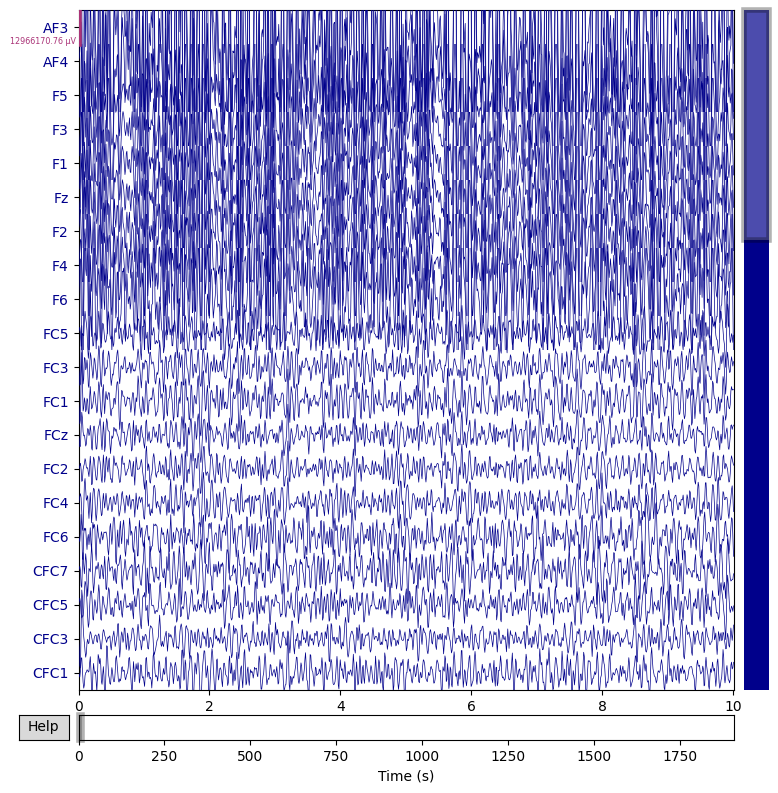

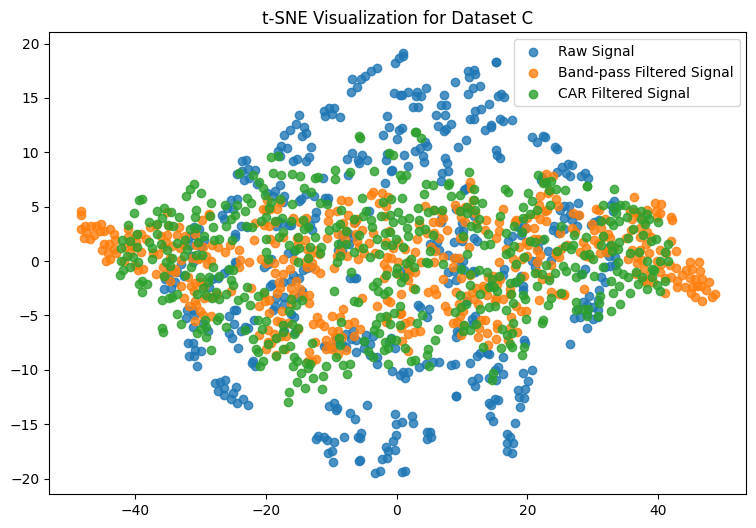

Computing rank from data with rank=None
    Using tolerance 1.8e+02 (2.2e-16 eps * 59 dim * 1.4e+16  max singular value)
    Estimated rank (data): 58
    data: rank 58 computed from 59 data channels with 0 projectors
    Setting small data eigenvalues to zero (without PCA)
Reducing data rank from 59 -> 58
Estimating class=-1 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.


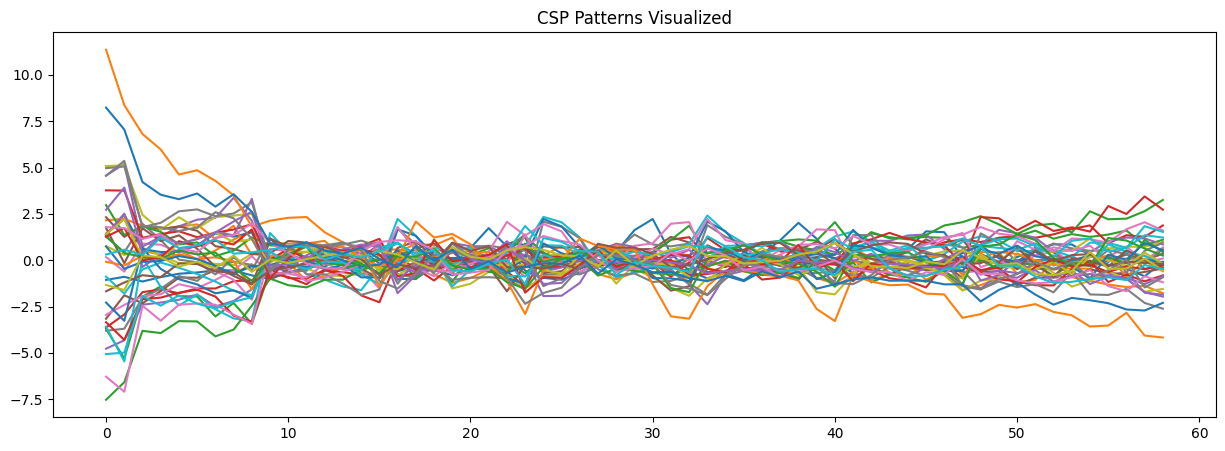

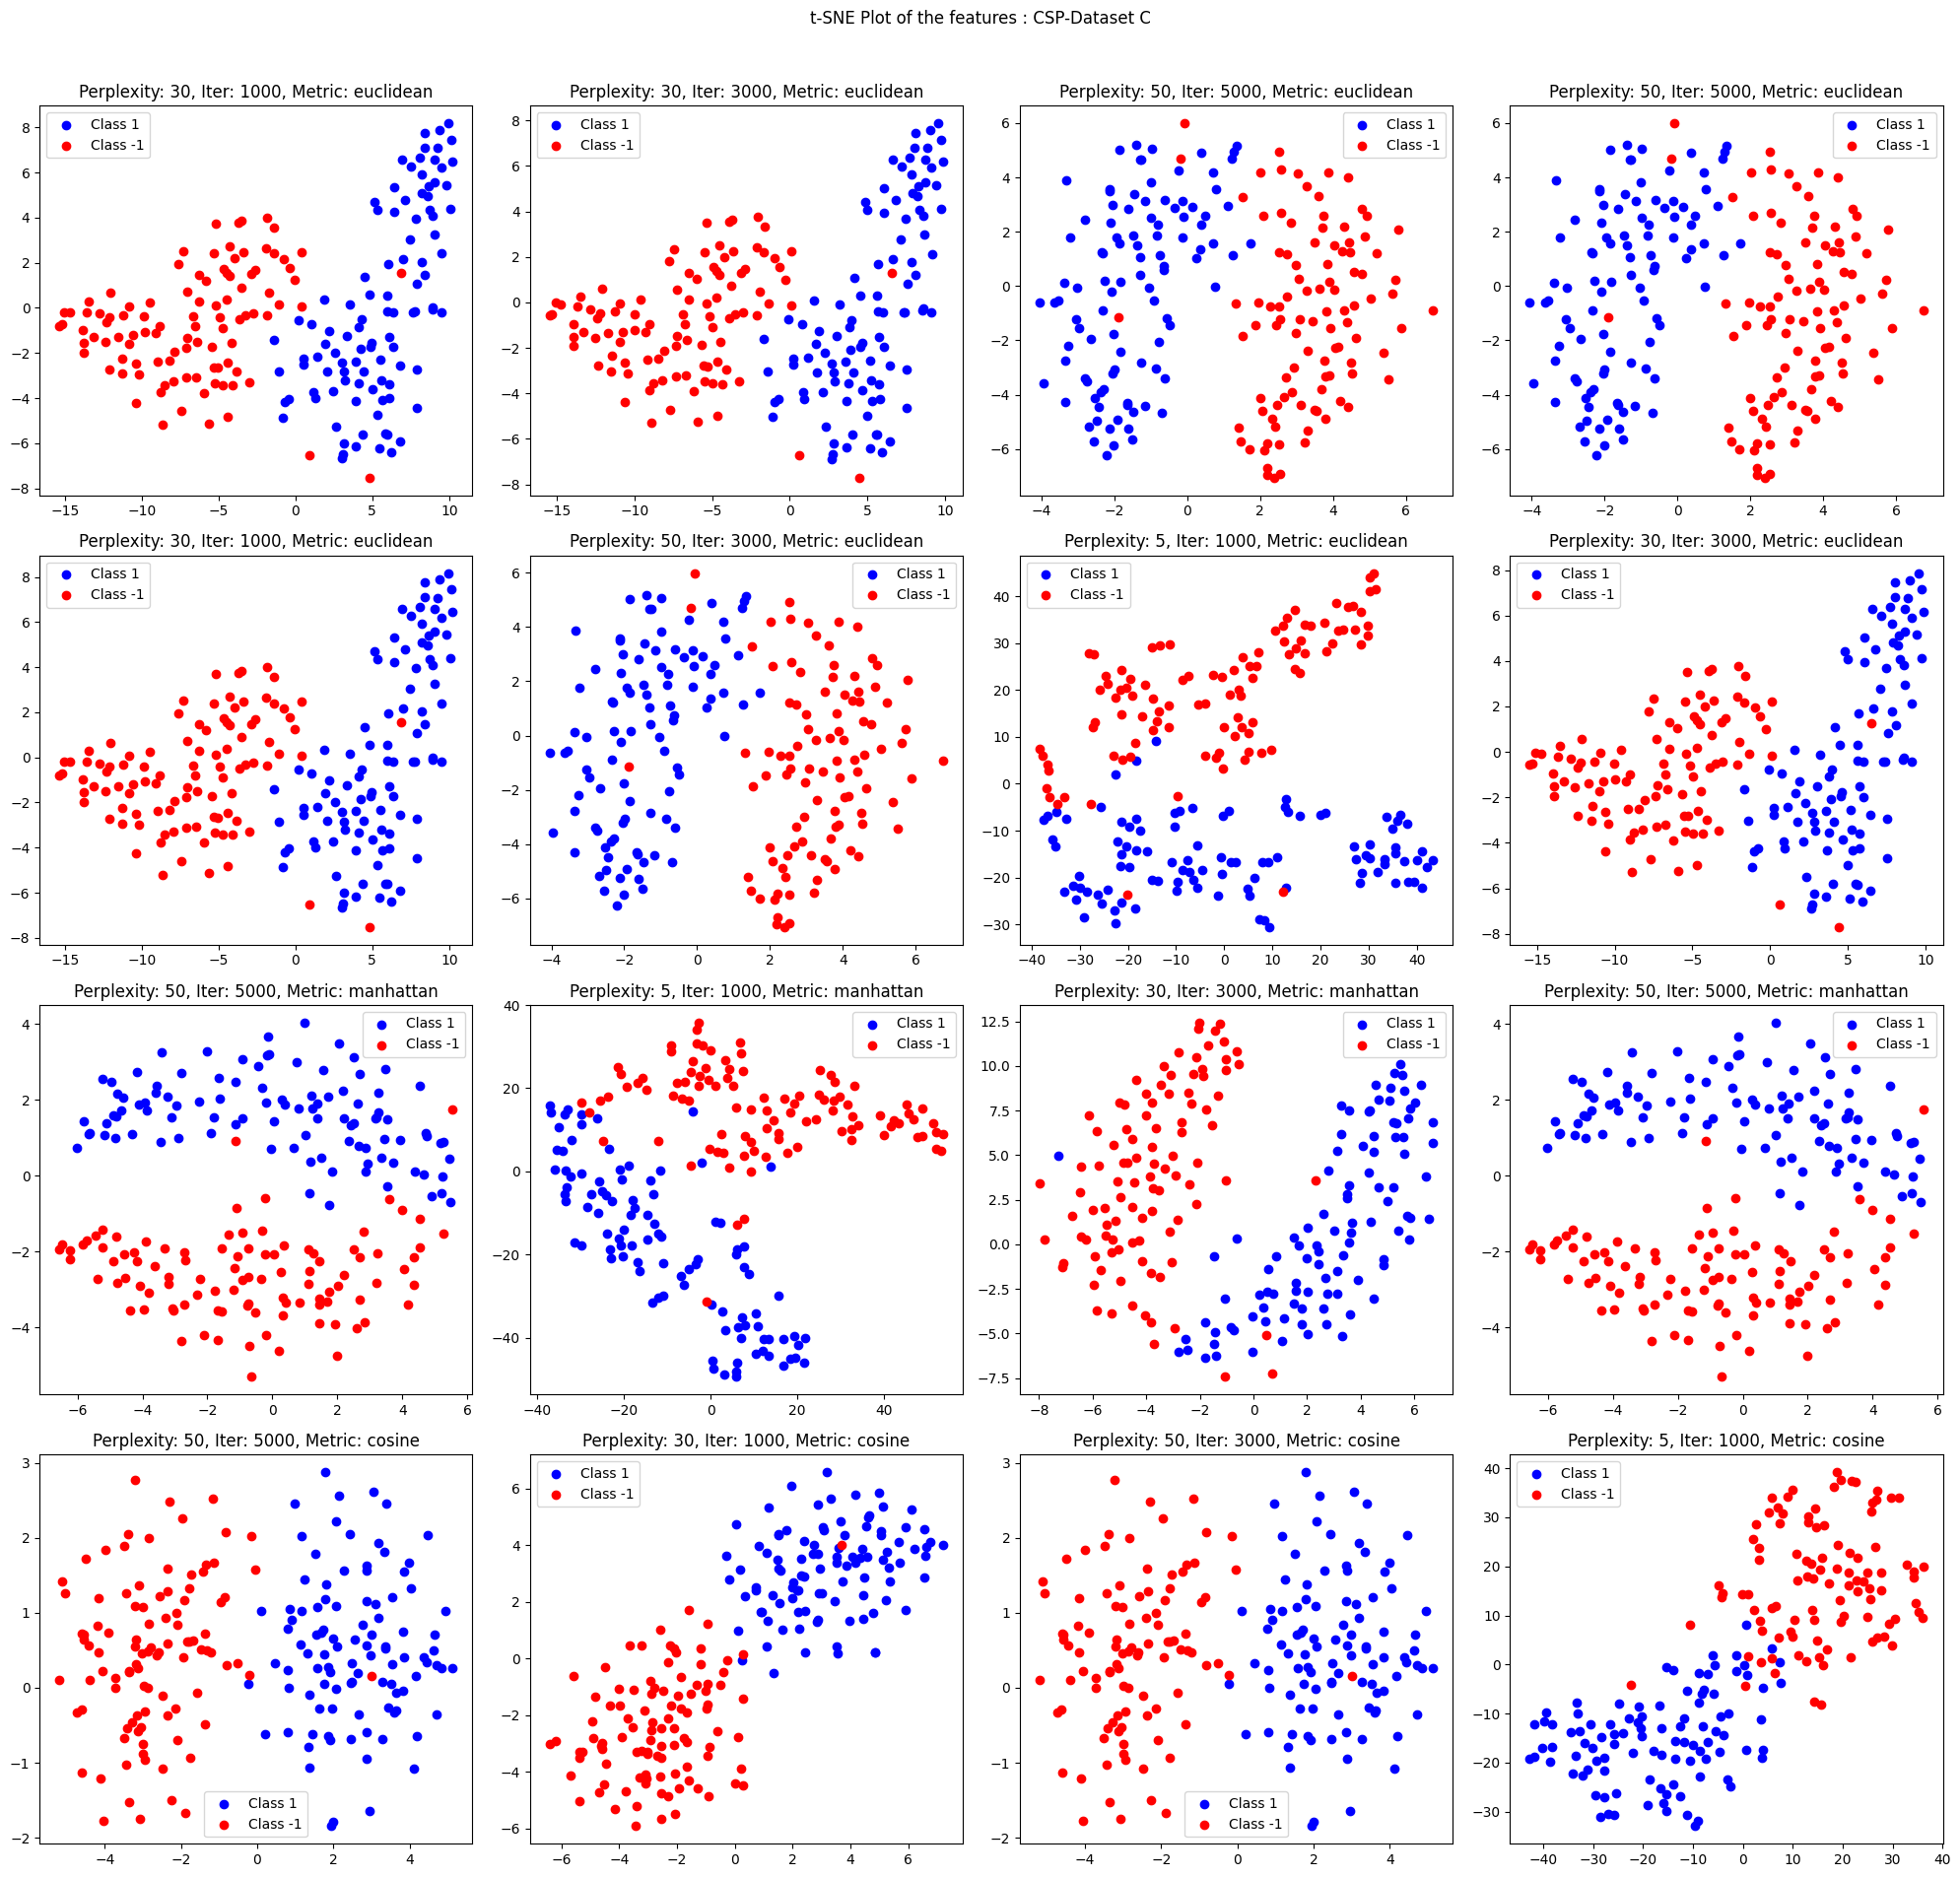

In [91]:
# Visualize raw EEG data
visualize_EEG(cnt_alt, "Raw EEG Plot for Dataset C", clab_alt, fs_alt)

# Create a plot of events
plt.figure(figsize=(8, 3))
plt.scatter(pos_alt, y_alt, s=7.1, color="darkblue")
plt.xlabel('Time (samples)')
plt.ylabel('Event Class')
plt.title('EEG Events')
plt.legend()
plt.grid(True)
plt.show()

# Apply the bandpass filter for 8-30 hrz
bandpass_cnt_alt = bandpass_filter(cnt_alt, 8, 30, fs_alt)

# Visualize bandpass filtered EEG data
visualize_EEG(bandpass_cnt_alt, " EEG Plot", clab_alt, fs_alt)

# Apply CAR to reduce noise
CAR_cnt_alt = common_average_reference(bandpass_cnt_alt)

# Visualize CAR filtered data
visualize_EEG(CAR_cnt_alt, "CAR Applied EEG", clab_alt, fs_alt)

# Apply t-SNE to 2D
tsne = TSNE(n_components=2)
tsne_cnt1_alt = tsne.fit_transform(CAR_cnt_alt[:500, :])
tsne_cnt2_alt = tsne.fit_transform(bandpass_cnt_alt[:500, :])
tsne_cnt3_alt = tsne.fit_transform(cnt_alt[:500, :])

# Plot the t-SNE visualization
fig, ax  = plt.subplots(figsize=(9,6))
plt.scatter(tsne_cnt3_alt[:, 0], tsne_cnt3_alt[:, 1], alpha=0.8, label="Raw Signal")
plt.scatter(tsne_cnt2_alt[:, 0], tsne_cnt2_alt[:, 1], alpha=0.8, label="Band-pass Filtered Signal")
plt.scatter(tsne_cnt1_alt[:, 0], tsne_cnt1_alt[:, 1], alpha=0.8, label="CAR Filtered Signal")
plt.title('t-SNE Visualization for Dataset C')
plt.legend()
plt.show()

# List of EEG's to visualize
cnt_list_1_alt = [cnt_alt[:500, 0], bandpass_cnt_alt[:500, 0], CAR_cnt_alt[:500, 0]]
label_list_1_alt = ["Raw Signal", "Band-pass Filtered Signal", "CAR Filtered Signal"]

# Segment the data to be used for model training
seg_data_alt, labels_alt = segment_data(CAR_cnt_alt, y_alt, -50, 350)

# Apply CSP
csp_data_alt = common_spatial_patterns(seg_data_alt, labels_alt
                                   , component_num=41, plot=True)

# Plot the features using t-SNE
plot_tsne_feature_extract(csp_data_alt, labels_alt, title="CSP-Dataset C")


----------------------- 1. Support Vector Machine with Linear Kernel -----------------------

Support Vector Machine with Linear Kernel Accuracy: 100.0%
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

[[25  0]
 [ 0 25]]


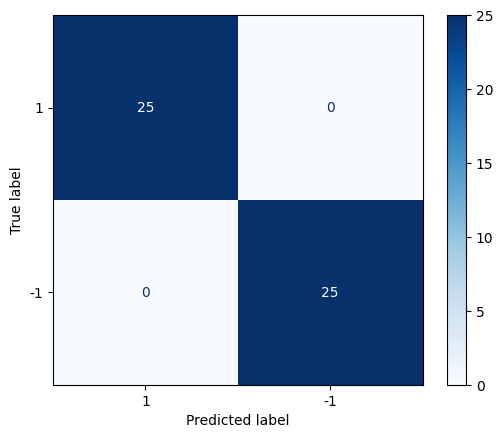

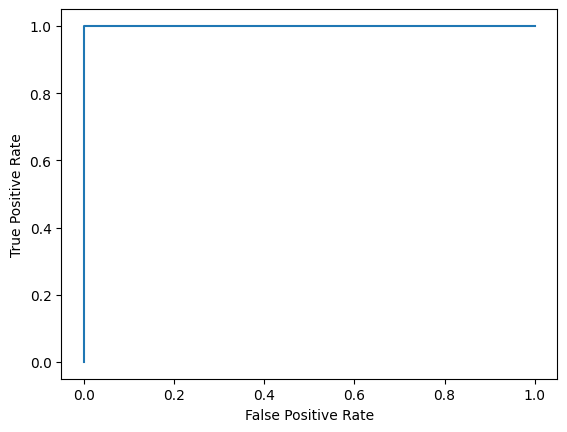


----------------------- 2. Support Vector Machine with RBF Kernel -----------------------

Support Vector Machine with RBF Kernel Accuracy: 98.0%
              precision    recall  f1-score   support

          -1       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

[[24  1]
 [ 0 25]]


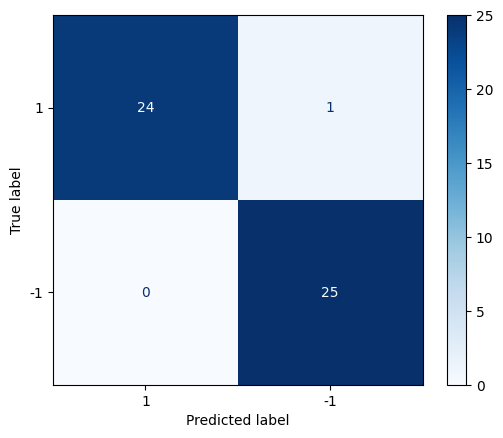

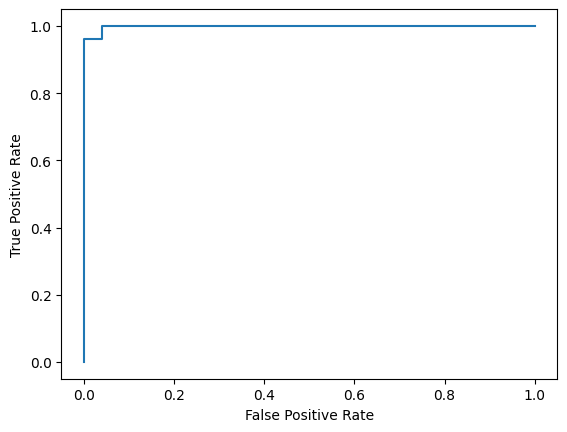


----------------------- 3. Logistic Regression -----------------------

Logistic Regression Accuracy: 100.0%
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

[[25  0]
 [ 0 25]]


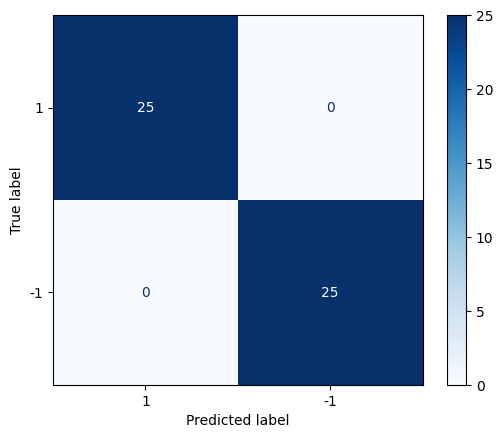

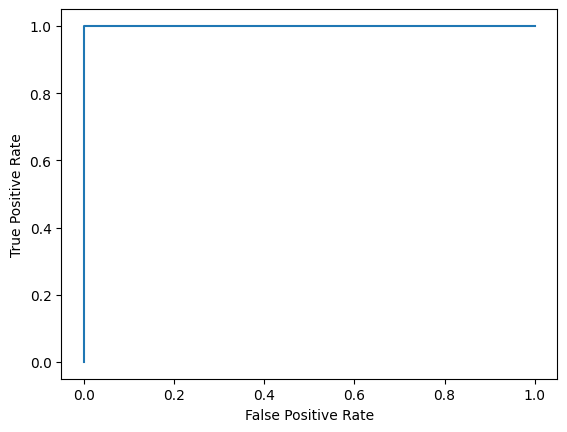


----------------------- 4. Multilayer Perceptron -----------------------

Multilayer Perceptron Accuracy: 100.0%
              precision    recall  f1-score   support

          -1       1.00      1.00      1.00        25
           1       1.00      1.00      1.00        25

    accuracy                           1.00        50
   macro avg       1.00      1.00      1.00        50
weighted avg       1.00      1.00      1.00        50

[[25  0]
 [ 0 25]]


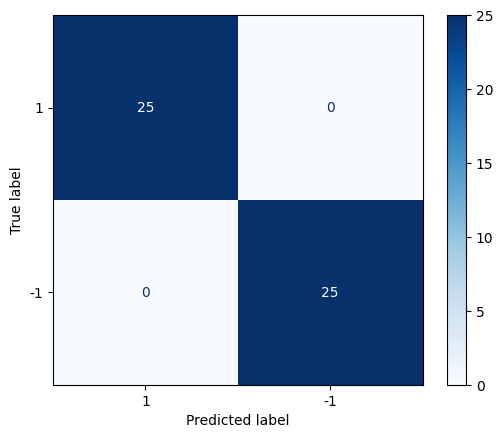

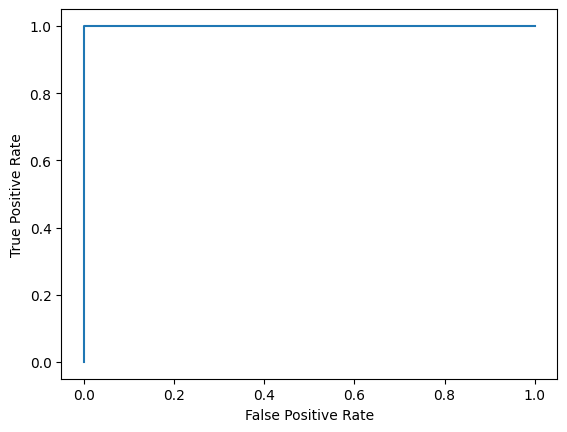


----------------------- 5. K-Nearest Neighbors -----------------------

K-Nearest Neighbors Accuracy: 98.0%
              precision    recall  f1-score   support

          -1       1.00      0.96      0.98        25
           1       0.96      1.00      0.98        25

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50

[[24  1]
 [ 0 25]]


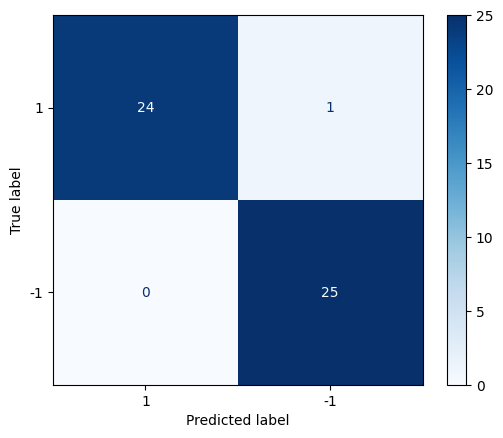

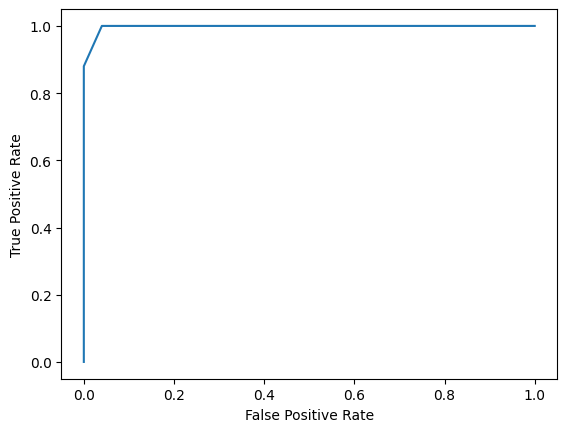

In [94]:
fit_classify(*train_test_normalize_split(csp_data_alt, labels_alt), 5)

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 2,            Silhouette Score: 0.188280846861299
Number of clusters: 3,            Silhouette Score: 0.13921078215576885
Number of clusters: 4,            Silhouette Score: 0.12837976498965264
Number of clusters: 5,            Silhouette Score: 0.11416317928447865
Number of clusters: 6,            Silhouette Score: 0.09607754291953167


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 7,            Silhouette Score: 0.08833152099038372
Number of clusters: 8,            Silhouette Score: 0.08744021148019625


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of clusters: 9,            Silhouette Score: 0.07698350525776579


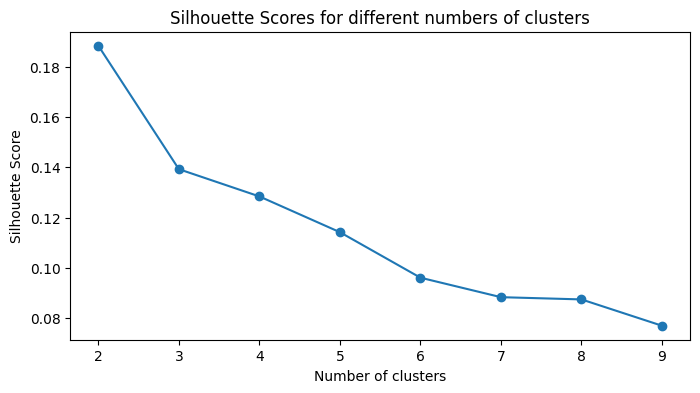

Optimal number of clusters according to         silhouette score: 2


In [95]:
# Perform K-means
k_means(csp_data_alt)

In [96]:
# K-means with 2 clusters
specific_kmeans(csp_data_alt, labels_alt, number_clusters=2)

Center(centroid) of clusters in KMEANS method  with         $n_clusters=2$ are as follows:

 [[-0.76498227 -0.7736695  -0.77429331 -0.78824837 -0.7844087  -0.78787944
  -0.7400113  -0.75391472 -0.77463365 -0.78369258 -0.7747212  -0.76132674
  -0.77522252 -0.76366589 -0.76444178 -0.75921887 -0.76879749 -0.7509315
  -0.76509481 -0.77121803 -0.78570665 -0.76894171 -0.77299345 -0.7619261
  -0.75940009 -0.7619303  -0.76373241 -0.77962872 -0.7554498  -0.77567875
  -0.76041417 -0.74928703 -0.7571099  -0.7428479  -0.77676176 -0.75675793
  -0.74720329 -0.75497796 -0.75840268 -0.75520361 -0.75423597]
 [-0.70944257 -0.6089554  -0.59947017 -0.58757556 -0.58523044 -0.58387984
  -0.64536955 -0.62583603 -0.59966573 -0.58891968 -0.60231546 -0.61755234
  -0.59600451 -0.61703183 -0.61399304 -0.61955235 -0.6039507  -0.62920648
  -0.60952903 -0.60619987 -0.58572511 -0.60333303 -0.59844356 -0.61407363
  -0.61606025 -0.61247521 -0.61167329 -0.58920118 -0.61822449 -0.5927691
  -0.61575182 -0.62959742 -0.6172

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [97]:
# K-means with 5 clusters
specific_kmeans(csp_data_alt, labels_alt, number_clusters=5)

Center(centroid) of clusters in KMEANS method  with         $n_clusters=5$ are as follows:

 [[-0.498252   -0.70435704 -0.6827985  -0.65281841 -0.65589194 -0.65790505
  -0.51804867 -0.49986608 -0.68581915 -0.44733863 -0.67511802 -0.50818688
  -0.65534191 -0.50831952 -0.51297698 -0.52846942 -0.61498577 -0.68822645
  -0.63096956 -0.49768528 -0.48826939 -0.63976487 -0.62873332 -0.5141277
  -0.53443658 -0.64031107 -0.52695374 -0.62601371 -0.63544695 -0.63302649
  -0.55724427 -0.56637496 -0.64077079 -0.59055214 -0.58675072 -0.63189692
  -0.59223478 -0.59012503 -0.6259759  -0.56007474 -0.60259249]
 [-0.94657251 -0.62421228 -0.64764025 -0.65606523 -0.66076603 -0.65385813
  -0.80142566 -0.77924087 -0.65652581 -0.80252325 -0.66328759 -0.79643939
  -0.67494038 -0.78276613 -0.79837204 -0.79166629 -0.65677149 -0.67569827
  -0.67147653 -0.76152602 -0.79254548 -0.67181043 -0.70013139 -0.77474645
  -0.78051416 -0.69523097 -0.7704857  -0.69513894 -0.66746521 -0.70747098
  -0.75674389 -0.77170167 -0.67

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [98]:
# K-means with 9 clusters
specific_kmeans(csp_data_alt, labels_alt, number_clusters=9)

Center(centroid) of clusters in KMEANS method  with         $n_clusters=9$ are as follows:

 [[-0.25491134 -0.87453017 -0.82605886 -0.75607076 -0.78585673 -0.84112353
  -0.59011873 -0.62103897 -0.72014536 -0.67998973 -0.74990681 -0.64784229
  -0.74631139 -0.62691196 -0.70386205 -0.64837729 -0.76980605 -0.71941523
  -0.73149532 -0.69182263 -0.63688382 -0.77756704 -0.78181627 -0.70585546
  -0.71641732 -0.72965306 -0.70602636 -0.72060522 -0.74633403 -0.71191185
  -0.6591596  -0.67478054 -0.7147261  -0.69468084 -0.76389074 -0.72296415
  -0.65527653 -0.64597592 -0.69587506 -0.66341909 -0.75028514]
 [-1.10931804 -0.64663762 -0.75497981 -0.74807566 -0.77709542 -0.79540113
  -0.82033163 -0.87531676 -0.7485614  -0.87311017 -0.756283   -0.85300937
  -0.74589097 -0.83936102 -0.90480229 -0.86282626 -0.72955367 -0.67843197
  -0.7411057  -0.89649967 -0.86144216 -0.78066851 -0.79442092 -0.85263426
  -0.83227949 -0.75949459 -0.83958121 -0.80764638 -0.74227064 -0.81300945
  -0.83929644 -0.81647049 -0.7

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


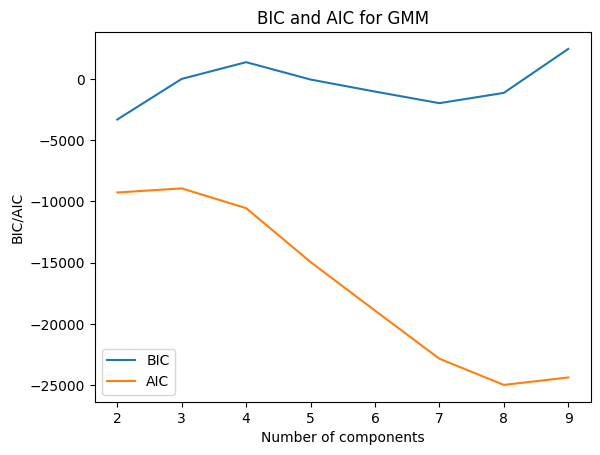

Optimal number of components according to BIC: 2


In [102]:
best_gmm(csp_data_alt)

Number of components: 2, Silhouette Score: 0.1847416790964504
Number of components: 3, Silhouette Score: 0.13642483442219125
Number of components: 4, Silhouette Score: 0.1167600813921243
Number of components: 5, Silhouette Score: 0.11604906063661904
Number of components: 6, Silhouette Score: 0.0934582048369348
Number of components: 7, Silhouette Score: 0.07845680293174936
Number of components: 8, Silhouette Score: 0.07599180765486122
Number of components: 9, Silhouette Score: 0.06458818560261614


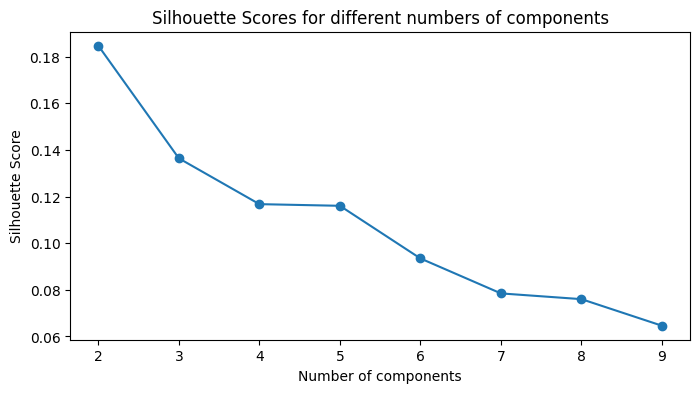

Optimal number of components according to silhouette score: 2


In [103]:
# Find optimal number of components
optimal_gmm(csp_data_alt)

In [104]:
# GMM with 2 components
apply_gmm(csp_data_alt, labels_alt)

Number of components: 2, Silhouette Score: 0.1847416790964504
Number of components: 2, Homogeneity Score: 0.004905722222957016


In [105]:
# GMM with 5 components
apply_gmm(csp_data_alt, labels_alt, 5)

Number of components: 5, Silhouette Score: 0.11604906063661904
Number of components: 5, Homogeneity Score: 0.7817345474372681


In [106]:
# GMM with 9 components
apply_gmm(csp_data_alt, labels_alt, 9)

Number of components: 9, Silhouette Score: 0.06458818560261614
Number of components: 9, Homogeneity Score: 0.8275706537730032
